In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import old_references.nonlinear_QM_FPJPA as Fs
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import standard_sequences.rabi_ef_no_swap as rabi_ef_no_swap
import classifiers.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
big_agilent_address = 'GPIB0::30::INSTR'
bnc.set_bnc_output(8.33, power_dBm=-2, bnc_addr=big_agilent_address)
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)



Qubit(ge_ssm=-0.11, qubit_id=q1, RO_LO=6.6247, ROIF=0.10280000000000022, ge_amp=1.2, ef_ssm=-0.255, ro_amp=0.6, qubit_thr=[-10000, -600], ef_amp=1, ge_time=52.17178532987394, ro_freq=6.7275, RO_LO_pwr=16, ro_dur=4000, ef_time=76.411, IQ_angle=205, RO_IF=0.030850000000000044)
Qubit(ge_ssm=-0.152, qubit_id=q2, RO_LO=6.6247, ROIF=0.030850000000000044, ge_amp=1.2, ef_ssm=-0.224, ro_amp=0.4, qubit_thr=[-10000, 1900], ef_amp=1, ge_time=40.15374412400174, ro_freq=6.65555, RO_LO_pwr=16, ro_dur=4000, ef_time=None, IQ_angle=85, RO_IF=0.10280000000000022)


In [ ]:
spyder_IQ = pd.read_csv('rabi_raw_IQ_data.csv')
# Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
spyder_IQ = classifier.classify(spyder_IQ)
spyder_states = spyder_IQ['predicted']
spyder_reps =10000
# Reshape the predicted states.
# (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
#  where each row corresponds to a time step and holds all the state measurements for that step.)
spyder_states_reshaped= classifier.reshape_for_exp(spyder_states, spyder_reps, 51)
spyder_probabilties = classifier.probabilities(spyder_states_reshaped)
spyder_population = classifier.population(spyder_states_reshaped)
spyder_sweep_time = 50000
# Compute time values as the index for the DataFrame.
times = np.linspace(0, spyder_sweep_time/1000, 51)

# Build a DataFrame that holds the probability vs. time.
spyder_df_prob = pd.DataFrame({
    'time': times,
    'P_f': spyder_probabilties['P_f'],
    'P_e': spyder_probabilties['P_e'],
    'P_g': spyder_probabilties['P_g']
}, index=times)

In [ ]:
def run_rabi_ef_swap(q1: object, q2: object, general_vals_dict: dict,
                     num_steps: int, sweep_time: float,
                     swap_freq: float, swap_time: float, reps: int):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.
    
    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as 
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.rabi_ef_swap(q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time)
    wx.wx_set_and_amplitude_and_offset(amp=general_vals_dict["wx_amps"],
                                       offset=general_vals_dict["wx_offs"])
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(q1, q2,
                                num_patterns=num_steps,
                                num_records_per_pattern=reps,
                                verbose=True)
    
    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]
    
    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({
        "I1": I1_raw,
        "Q1": Q1_raw,
        "I2": I2_raw,
        "Q2": Q2_raw
    })
    
    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified['predicted']
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)
    
    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time/1000, num_steps)
    
    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame({
        'time': times,
        'P_f': probabilties['P_f'],
        'P_e': probabilties['P_e'],
        'P_g': probabilties['P_g']
    }, index=times)

    df_pop = pd.DataFrame({
        'time': times,
        'Pop_f': population['Pop_f'],
        'Pop_e': population['Pop_e'],
        'Pop_g': population['Pop_g']
    }, index=times)
    
    return df_prob,df_pop, values


def sweep_J(J_start: float, J_stop: float, J_steps: int):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a 
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.
    
    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as 
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    probs_folder = os.path.join("sweep_J_data", "probs")
    values_folder = os.path.join("sweep_J_data", "values")
    os.makedirs(probs_folder, exist_ok=True)
    os.makedirs(values_folder, exist_ok=True)
    num_steps = 51
    reps = 12000
    sweep_time =50000
    swap_freq=-.021
    swap_time=213

    # Create an array of frequency values
    J_vals = np.linspace(J_start, J_stop, J_steps)
    
    # Initialize the dictionary with frequency keys set to None (or an empty placeholder)
    return_dict = {}
    return_vals ={}
    # Loop over frequencies and populate the dictionary
    for J in J_vals:
        prob_filename = os.path.join(probs_folder, f"j={J}.pkl")
        values_filename = os.path.join(values_folder, f"j={J}.pkl")
        
        # If both files already exist, load them and skip this iteration
        if os.path.exists(prob_filename) and os.path.exists(values_filename):
            with open(prob_filename, "rb") as f:
                df_prob = pickle.load(f)
            with open(values_filename, "rb") as f:
                values = pickle.load(f)
            return_dict[J] = df_prob
            return_vals[J] = values
            continue  # Skip to the next J value
        
        a_to_J = (((2*np.pi)/(2*(2*q1.ef_time*10**-3))))#if J is in units of rad/micros 
        J_to_a = 1/a_to_J
        q1.ef_ssm =-0.25275
        ef_amp=J * J_to_a 
        q1.ef_amp = ef_amp 
        df_prob, df_pop, values = run_rabi_ef_swap(q1, q2, general_vals_dict, num_steps,
                                   sweep_time, swap_freq, swap_time, reps)
        # Populate the dictionary at the corresponding frequency key
        return_dict[J] = df_prob
        return_vals[J] = values

        # Create filenames with the current J value
        prob_filename = os.path.join(probs_folder, f"j={J}.pkl")
        values_filename = os.path.join(values_folder, f"j={J}.pkl")
        
        # Save df_prob to a pickle file
        with open(prob_filename, "wb") as f:
            pickle.dump(df_prob, f)
        
        # Save values to a pickle file
        with open(values_filename, "wb") as f:
            pickle.dump(values, f)

    return return_dict, return_vals


In [ ]:
# Define the new directory path for probability files (using a raw string for Windows paths)
probs_folder = r"C:\Users\quantum1\OneDrive\Documents\Python Scripts\Important Blue Fridge Python Files\New\nonlin_data\sweep_J_data\probs"

# Generate the list of J values from 0 to 0.5 with 51 steps
J_vals = np.linspace(0, 0.5, 51)

# Dictionary to store the loaded DataFrames
probability_dataframes = {}

# Loop over each J value and load the corresponding pickle file
for J in J_vals:
    # Format the filename. Adjust the formatting as needed so that it matches your saved file names.
    filename = os.path.join(probs_folder, f"j={J}.pkl")
    
    # Check if the file exists before loading
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            df_prob = pickle.load(f)
        probability_dataframes[J] = df_prob
    else:
        print(f"File not found: {filename}")

# Now 'probability_dataframes' is a dictionary mapping each J value to its DataFrame.
print(probability_dataframes[.1])

{0.0:       time       P_f       P_e       P_g
0.0    0.0  0.027750  0.764000  0.208250
1.0    1.0  0.026750  0.267500  0.705750
2.0    2.0  0.024833  0.106500  0.868667
3.0    3.0  0.019083  0.053167  0.927750
4.0    4.0  0.018167  0.040083  0.941750
5.0    5.0  0.017917  0.032833  0.949250
6.0    6.0  0.017750  0.029500  0.952750
7.0    7.0  0.016250  0.033083  0.950667
8.0    8.0  0.018833  0.029750  0.951417
9.0    9.0  0.015000  0.029917  0.955083
10.0  10.0  0.017500  0.031417  0.951083
11.0  11.0  0.014917  0.030667  0.954417
12.0  12.0  0.018250  0.029500  0.952250
13.0  13.0  0.016000  0.028917  0.955083
14.0  14.0  0.018000  0.029583  0.952417
15.0  15.0  0.016500  0.028000  0.955500
16.0  16.0  0.014250  0.027583  0.958167
17.0  17.0  0.017583  0.027167  0.955250
18.0  18.0  0.016167  0.029250  0.954583
19.0  19.0  0.014667  0.027833  0.957500
20.0  20.0  0.015167  0.029667  0.955167
21.0  21.0  0.015583  0.028750  0.955667
22.0  22.0  0.015500  0.032500  0.952000
23.0  23.0

In [ ]:
def sweep_J_curve_fit(probability_dataframes):
    """
    Loops over each J in the probability_dataframes dictionary, performs a 
    renormalization and curve fit on the P_f data, and returns a dictionary
    mapping J values to the extracted Rabi angular frequency.

    Parameters:
        probability_dataframes (dict): Dictionary with keys as J values and values as 
                                       DataFrames containing columns 'time', 'P_f', 'P_e', etc.
        guess_gamma (float): Initial guess for gamma used in the curve fit for J <= 0.25.
        guess_freq (float): Initial guess for frequency used in the curve fit for J > 0.25.

    Returns:
        omega_values (dict): Dictionary mapping each J value to its extracted angular frequency
                             in rad/µs.
    """
    omega_values = {}
    
    for J, df in probability_dataframes.items():
        # Extract the time and state probability data from the DataFrame
        times = df['time'].values
        P_f = df['P_f'].values
        P_e = df['P_e'].values
        
        # Renormalize: P_f_norm = P_f / (P_f + P_e)
        norm_factor = P_f + P_e
        # Avoid division by zero (if that case can ever occur)
        norm_factor[norm_factor == 0] = 1  
        
        guess_gamma=np.sqrt(abs(0.25**2-J**2))
        guess_freq=np.sqrt(abs(0.25**2-J**2))/np.pi
        # Select initial guess values based on J
        if J <= 0.1:
            P_f_norm = P_f
            guess_vals = [0.0000001, 0.0477, 0.1, -10, 0.5]
        else:
            P_f_norm = P_f / norm_factor
            guess_vals = [guess_freq, 0.2, 0.1, -10, 0.5]
        guess_vals = [guess_freq, guess_freq, 0.1, -10, 0.5]
        # Perform the curve fit using analysis.fit_sine_decay.
        # It is assumed that this function returns a tuple where the first element
        # is an array of fit parameters, with the first parameter corresponding to frequency.
        fit_vals_f, _, _, _ = analysis.fit_sine_decay(times, P_f_norm, guess_vals=guess_vals)
        
        # Calculate the angular frequency: omega = |(freq * 2π)|
        omega_rabi_f = abs(fit_vals_f[0] * 2 * np.pi)
        
        print(f"J = {J}: Angular freq (rad/µs): {omega_rabi_f}")
        omega_values[J] = omega_rabi_f

    return omega_values

# Example usage:
# Assuming you have already loaded your probability data into `probability_dataframes`
# and you have defined your guess values (e.g., guess_gamma=0.1 and guess_freq=0.005)
# omega_dict = sweep_J_curve_fit(probability_dataframes, guess_gamma=0.1, guess_freq=0.005)
# Now, omega_dict contains each J's angular frequency.


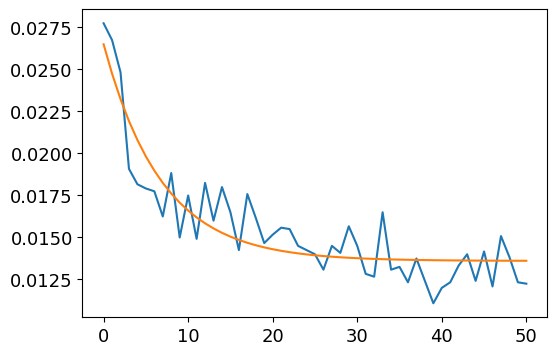



  freq: 4.733618575956362e-07 +/- 2.2827458807526684
 gamma: 0.14590852780571248 +/- 96.59369155991547
   amp: 0.06428080372807679 +/- 234080.82070647887
 phase: 11.573465028809435 +/- 42727450.66554616
offset: 0.01360403735975039 +/- 0.00038829223577196997
pi_pulse time: 1056274.3744070719 +/- 2.2827458807526684
J = 0.0: Angular freq (rad/µs): 2.9742202686241367e-06


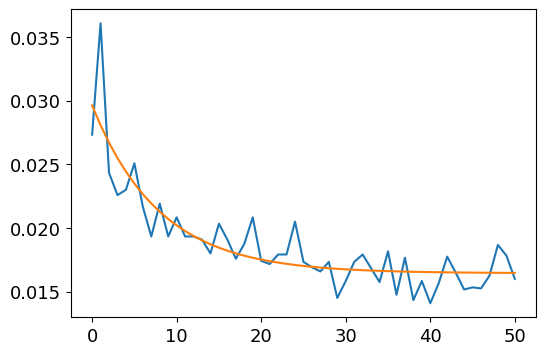



  freq: 1.9351742107619137e-07 +/- 1.3075137041289118
 gamma: 0.12550143784215906 +/- 86.59848279779679
   amp: 0.09558142460564147 +/- 247153.49588570467
 phase: 7.929766624546186 +/- 20636185.048235647
offset: 0.016445324280524212 +/- 0.0005419975279541142
pi_pulse time: 2583746.709827953 +/- 1.3075137041289118
J = 0.01: Angular freq (rad/µs): 1.2159058167892109e-06
RuntimeError


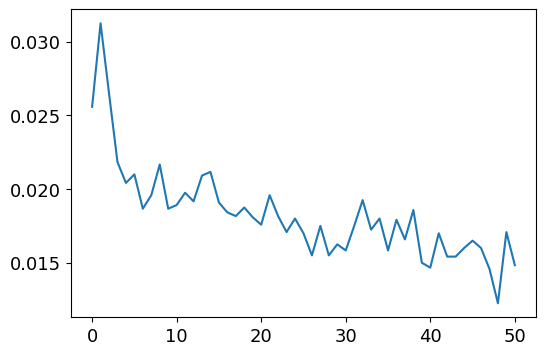



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.02: Angular freq (rad/µs): nan
RuntimeError


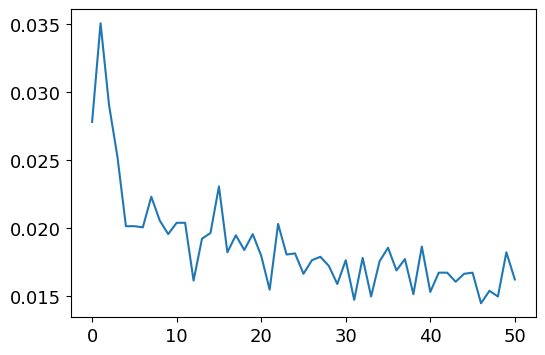



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.03: Angular freq (rad/µs): nan


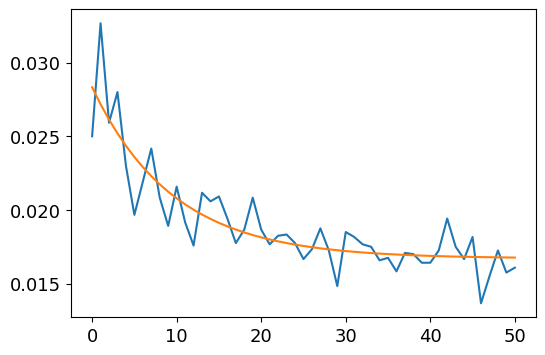



  freq: -7.752759559339776e-08 +/- 0.1942847084654724
 gamma: 0.1046509627920694 +/- 24.0808001851518
   amp: 0.17836254364018472 +/- 394857.33644861914
 phase: 3.735848307158573 +/- 8282126.332902705
offset: 0.016706364098508668 +/- 0.00046638140103590775
pi_pulse time: -6449316.481092829 +/- 0.1942847084654724
J = 0.04: Angular freq (rad/µs): 4.871202495333977e-07


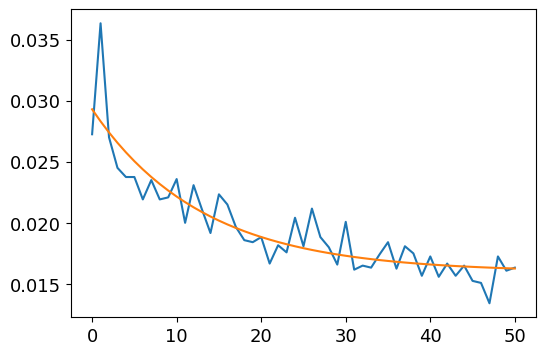



  freq: 1.6195690907596876e-07 +/- 0.3824596935342493
 gamma: 0.0768565328361523 +/- 45.2863592133001
   amp: 0.17134900027021044 +/- 419634.0554553439
 phase: 4.45781361548019 +/- 10939277.049486948
offset: 0.015975823060474174 +/- 0.0008731793136041746
pi_pulse time: 3087240.9386713235 +/- 0.3824596935342493
J = 0.05: Angular freq (rad/µs): 1.017605271502347e-06


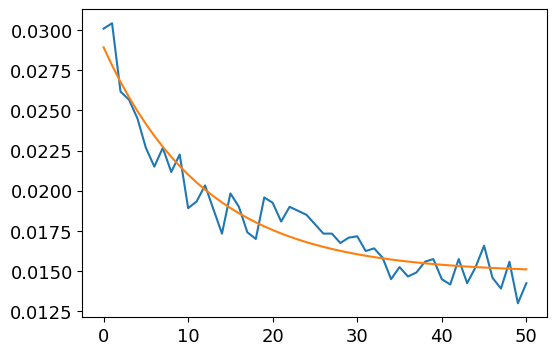



  freq: 5.104944640567064e-07 +/- 1.0983102750985656
 gamma: 0.08310700281476265 +/- 34.624864660632916
   amp: 0.062027144657522425 +/- 109827.52388160341
 phase: 13.073610144422396 +/- 23558901.75414852
offset: 0.014890328931553906 +/- 0.0005339096125424911
pi_pulse time: 979442.5507118906 +/- 1.0983102750985656
J = 0.06: Angular freq (rad/µs): 3.2075313159576148e-06


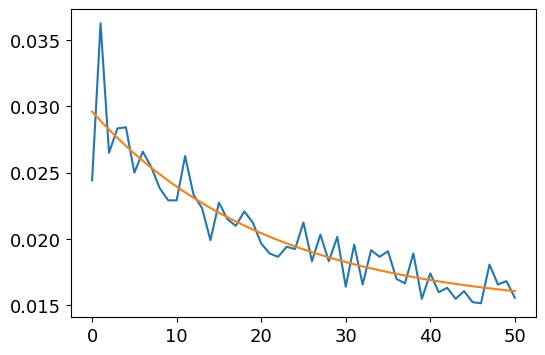



  freq: 2.0215431355464154e-08 +/- 0.04718521492386834
 gamma: 0.04773613555560582 +/- 3.86864452020623
   amp: 0.13881707450605832 +/- 363188.71076641325
 phase: 6.157554072331739 +/- 16172389.548388997
offset: 0.014712013915824836 +/- 0.0013413979069220971
pi_pulse time: 24733580.560716152 +/- 0.04718521492386834
J = 0.07: Angular freq (rad/µs): 1.270173012709499e-07


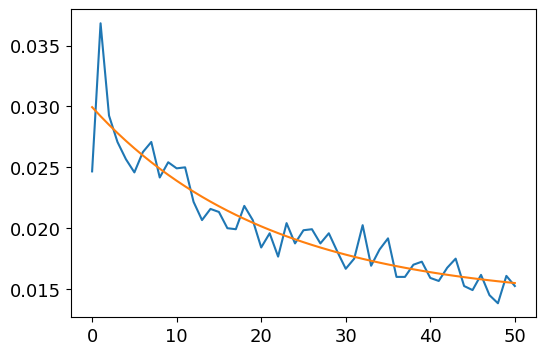



  freq: 1.3837301047347543e-07 +/- 0.34649351980598797
 gamma: 0.047813737424020696 +/- 26.533209279758672
   amp: 0.1646920099289337 +/- 385645.80007211573
 phase: 5.542316714134552 +/- 13018656.451681284
offset: 0.014037800124509421 +/- 0.0018315220631459858
pi_pulse time: 3613421.42003801 +/- 0.34649351980598797
J = 0.08: Angular freq (rad/µs): 8.694232663171479e-07
RuntimeError


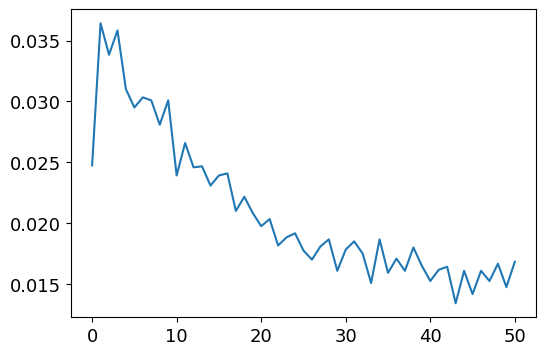



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.09: Angular freq (rad/µs): nan
RuntimeError


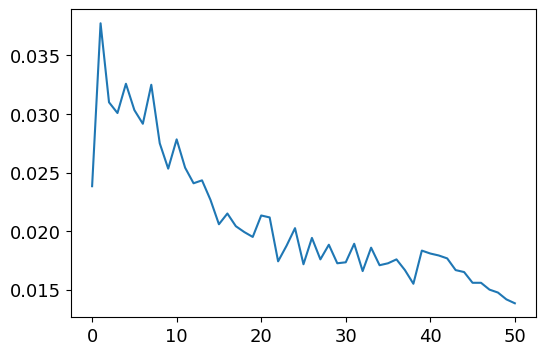



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.1: Angular freq (rad/µs): nan


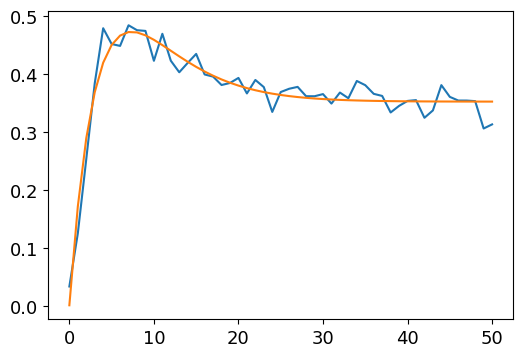



  freq: 0.006690796024291079 +/- 0.020186474690462294
 gamma: 0.21437158052365762 +/- 0.019326251516839622
   amp: 3.0308375875743434 +/- 9.25756970261186
 phase: -6.645185953787643 +/- 20.351743830096535
offset: 0.3525993770439543 +/- 0.005678775812987488
pi_pulse time: 74.7295236896685 +/- 0.020186474690462294
J = 0.11: Angular freq (rad/µs): 0.0420395112731613
RuntimeError


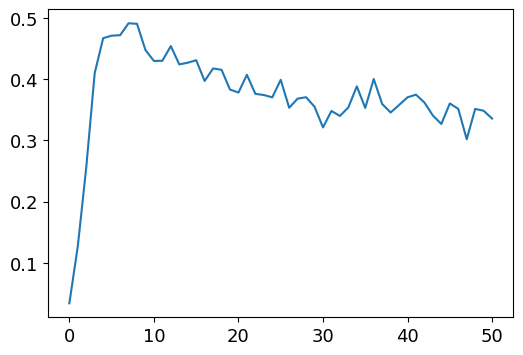



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.12: Angular freq (rad/µs): nan
RuntimeError


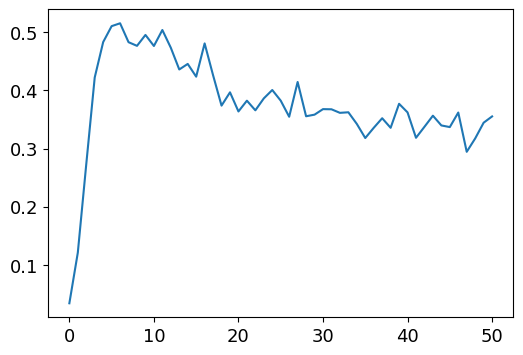



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.13: Angular freq (rad/µs): nan


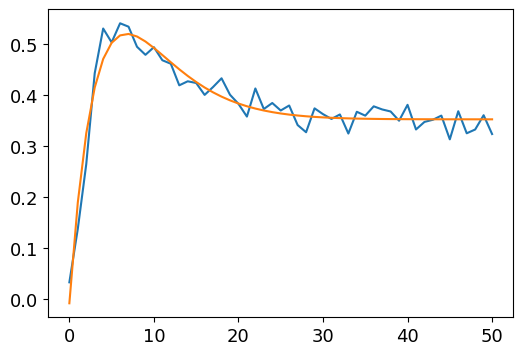



  freq: 0.010646111296039526 +/- 0.011368519643769039
 gamma: 0.21363150946423123 +/- 0.019319071370642128
   amp: 2.3957567442966887 +/- 2.6773743217880317
 phase: -8.661946555579373 +/- 9.659500863164647
offset: 0.35209595397417137 +/- 0.0061040523175987385
pi_pulse time: 46.965505628896224 +/- 0.011368519643769039
J = 0.14: Angular freq (rad/µs): 0.06689149007387417
RuntimeError


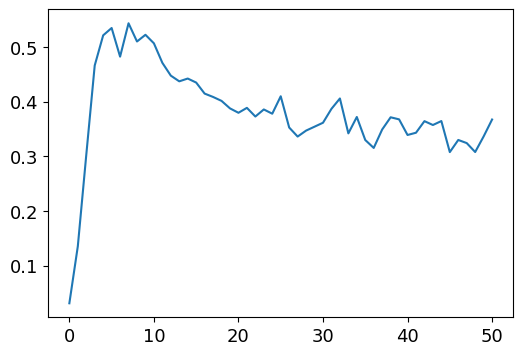



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.15: Angular freq (rad/µs): nan


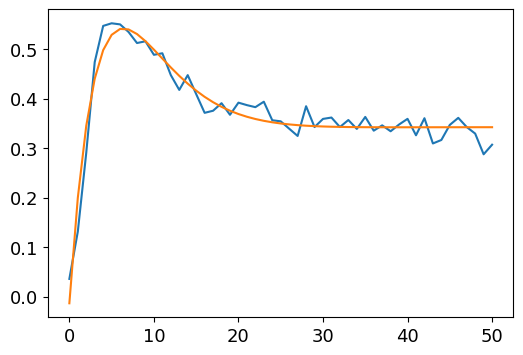



  freq: 0.015211443946968968 +/- 0.007376202560365047
 gamma: 0.21279083705777468 +/- 0.018992548118995544
   amp: 1.894238825085244 +/- 1.0185248929944126
 phase: -10.814600453325056 +/- 5.743652593683726
offset: 0.34217876391893254 +/- 0.005933827785188822
pi_pulse time: 32.86998931482964 +/- 0.007376202560365047
J = 0.16: Angular freq (rad/µs): 0.09557632110858127
RuntimeError


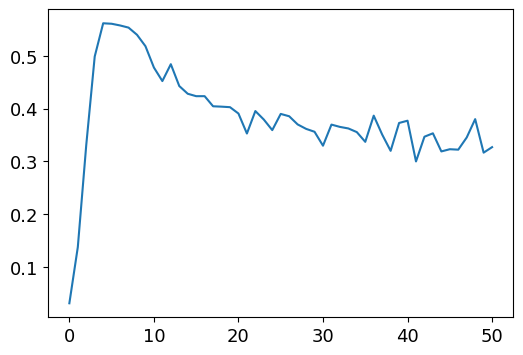



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.17: Angular freq (rad/µs): nan


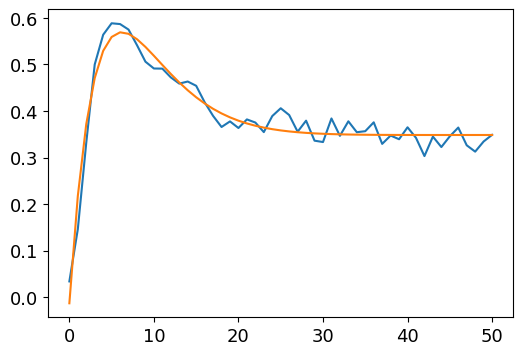



  freq: 0.013019549504848108 +/- 0.00825045081181452
 gamma: 0.21857987610500437 +/- 0.018345278047520484
   amp: 2.439936347550956 +/- 1.6711928276736063
 phase: -8.520850475313692 +/- 5.778620681747454
offset: 0.3485237283934316 +/- 0.0059757418184914314
pi_pulse time: 38.40378653760749 +/- 0.00825045081181452
J = 0.18: Angular freq (rad/µs): 0.08180424215495889


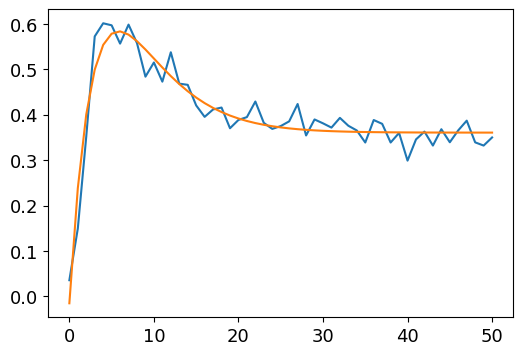



  freq: 0.004978316659993556 +/- 0.03235358913820091
 gamma: 0.24050743130389898 +/- 0.025471060659938004
   amp: 7.047300599402365 +/- 46.2179303051812
 phase: -3.05600597128057 +/- 20.032163685486516
offset: 0.3605591463933803 +/- 0.0076464932983639775
pi_pulse time: 100.43555566042421 +/- 0.03235358913820091
J = 0.19: Angular freq (rad/µs): 0.031279686092558864


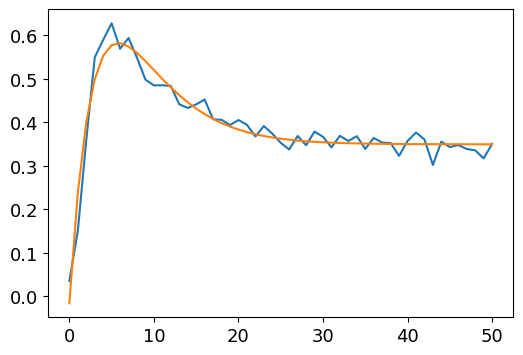



  freq: 0.002524796362543669 +/- 0.05094449015045085
 gamma: 0.23924146424194492 +/- 0.020818970378471927
   amp: 14.11669024845289 +/- 284.9265065815192
 phase: -1.4832842629220278 +/- 29.99870173277837
offset: 0.3496880091521892 +/- 0.006417152709733416
pi_pulse time: 198.03577326777457 +/- 0.05094449015045085
J = 0.2: Angular freq (rad/µs): 0.015863763408754845
RuntimeError


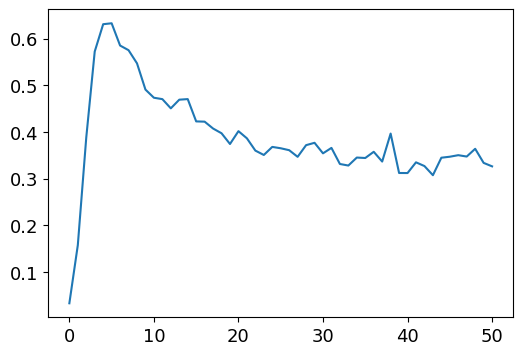



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.21: Angular freq (rad/µs): nan


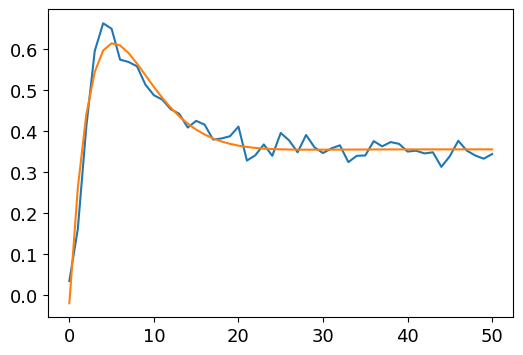



  freq: 0.02118222343525212 +/- 0.006550217851513124
 gamma: 0.2446385487957453 +/- 0.022107717087051074
   amp: 1.9379141106107678 +/- 0.704532071550588
 phase: -11.169270363265092 +/- 3.960535924100846
offset: 0.3549921021418465 +/- 0.005832885014470157
pi_pulse time: 23.60469860627966 +/- 0.006550217851513124
J = 0.22: Angular freq (rad/µs): 0.13309183506177122


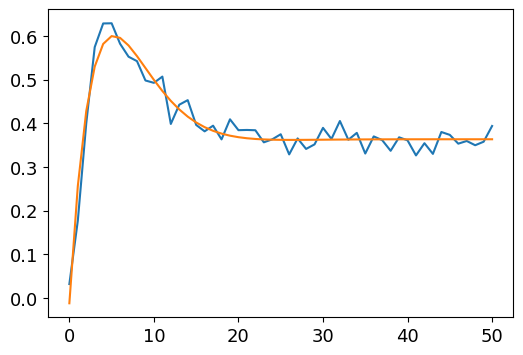



  freq: 0.023768357757700635 +/- 0.005840414957200141
 gamma: 0.24294273055519633 +/- 0.021426922192550896
   amp: 1.621755902162561 +/- 0.48103641864572033
 phase: -13.388417473029683 +/- 3.8652014527277494
offset: 0.3633002090707561 +/- 0.005301664064842453
pi_pulse time: 21.036371342820544 +/- 0.005840414957200141
J = 0.23: Angular freq (rad/µs): 0.14934099623897257


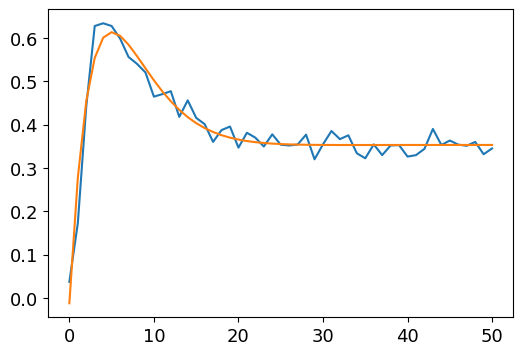



  freq: 0.017324355928311722 +/- 0.008611257890917386
 gamma: 0.25923661412999066 +/- 0.023057450183839413
   amp: 2.4654483303423573 +/- 1.3589351333503557
 phase: -8.513539540068313 +/- 4.616293574663591
offset: 0.35299614726656336 +/- 0.00570729420635941
pi_pulse time: 28.861101796165045 +/- 0.008611257890917386
J = 0.24: Angular freq (rad/µs): 0.10885213862511778


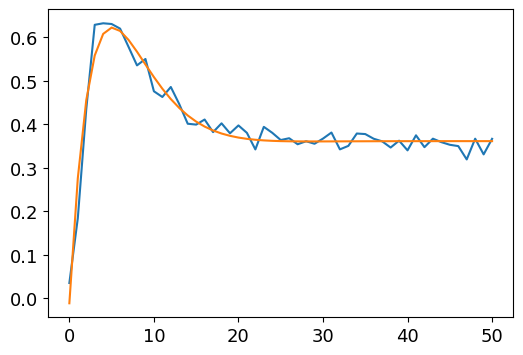



  freq: -0.02114149384386263 +/- 0.005997849231187565
 gamma: 0.2512470107113093 +/- 0.01984844954688821
   amp: 1.99927574752241 +/- 0.662413389894684
 phase: 190.7493488694742 +/- 3.4756839004139026
offset: 0.3614232036831438 +/- 0.005028249107293793
pi_pulse time: -23.650173620306866 +/- 0.005997849231187565
J = 0.25: Angular freq (rad/µs): 0.13283592349158535


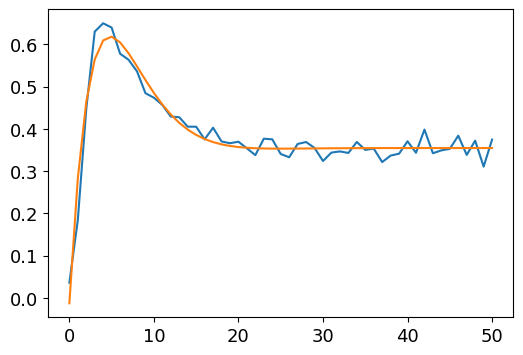



  freq: 0.024817454214953648 +/- 0.005894932493414881
 gamma: 0.25875451006294875 +/- 0.022224620546810014
   amp: 1.7761090126962056 +/- 0.5126456460224106
 phase: -11.934748849250935 +/- 3.3451605435674785
offset: 0.35459464285051834 +/- 0.005163660986648758
pi_pulse time: 20.147110806342386 +/- 0.005894932493414881
J = 0.26: Angular freq (rad/µs): 0.15593266368499886


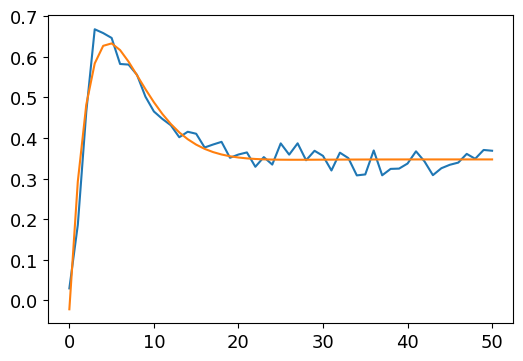



  freq: 0.022683275841204924 +/- 0.007021658319961363
 gamma: 0.26522371595254945 +/- 0.02440025554929602
   amp: 2.1041903630677714 +/- 0.7699721903683969
 phase: -10.093542530058235 +/- 3.5954900629475284
offset: 0.3471346827975056 +/- 0.005841758345099751
pi_pulse time: 22.042671592069315 +/- 0.007021658319961363
J = 0.27: Angular freq (rad/µs): 0.14252322548416044


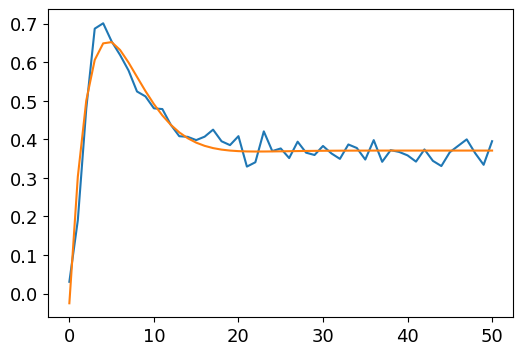



  freq: 0.028225409971702687 +/- 0.006297849757596753
 gamma: 0.2676593755841945 +/- 0.025848794175426498
   amp: 1.7527393754750675 +/- 0.48985217472883386
 phase: -13.063360320354203 +/- 3.5366851466316684
offset: 0.3709332018864942 +/- 0.00595478420563881
pi_pulse time: 17.714534545336054 +/- 0.006297849757596753
J = 0.28: Angular freq (rad/µs): 0.1773454812233225


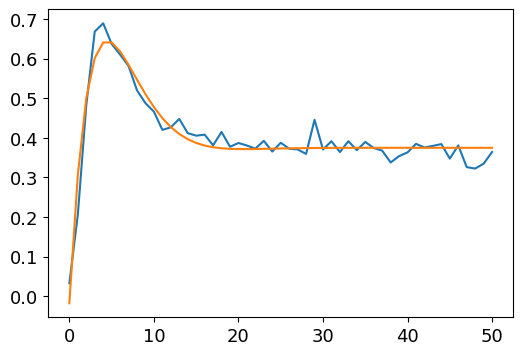



  freq: 0.030870034081690333 +/- 0.006014023420812033
 gamma: 0.27254320297062473 +/- 0.025906967591382637
   amp: 1.5798000975989694 +/- 0.39298339617686323
 phase: -14.389639792049072 +/- 3.4667850651233483
offset: 0.37471469541560154 +/- 0.005510494757036169
pi_pulse time: 16.196937090411588 +/- 0.006014023420812033
J = 0.29: Angular freq (rad/µs): 0.19396214457420977


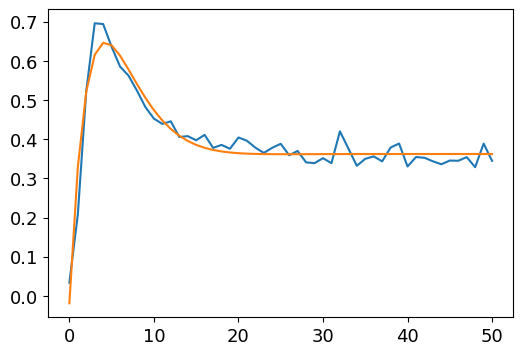



  freq: 0.023429011917269787 +/- 0.00922584835679799
 gamma: 0.29820698991274824 +/- 0.02953918409221698
   amp: 2.2888461649233625 +/- 1.0362166783173516
 phase: -9.58761327891795 +/- 4.250117772578364
offset: 0.3622035820426899 +/- 0.005928707910182123
pi_pulse time: 21.3410621739214 +/- 0.00922584835679799
J = 0.3: Angular freq (rad/µs): 0.14720882344032496


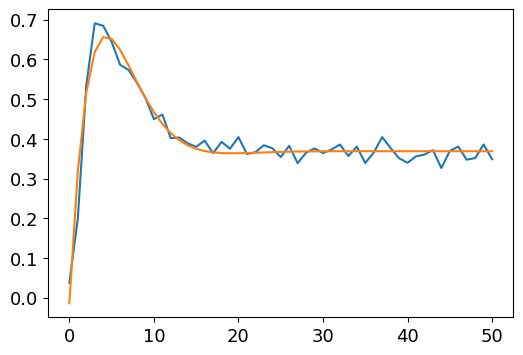



  freq: 0.033540812653140434 +/- 0.004912873013770385
 gamma: 0.269850430770134 +/- 0.023502481205288413
   amp: 1.5221140271429432 +/- 0.2997719624237555
 phase: -14.567167802312063 +/- 2.763247336291286
offset: 0.3688869418949695 +/- 0.005082513515441535
pi_pulse time: 14.90721185472484 +/- 0.004912873013770385
J = 0.31: Angular freq (rad/µs): 0.21074314125307514


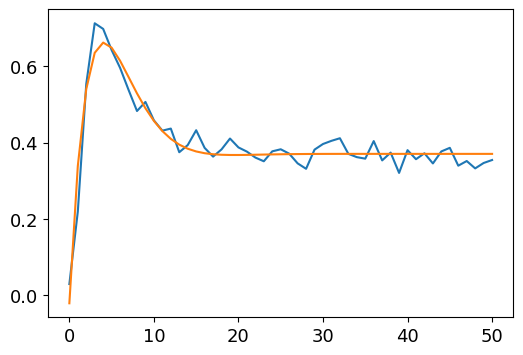



  freq: 0.03235612475903437 +/- 0.00700622976254299
 gamma: 0.29704796206945466 +/- 0.030036870109853526
   amp: 1.7326615639287621 +/- 0.47588863825732686
 phase: -13.0614565527944 +/- 3.482092487016216
offset: 0.3706685087790554 +/- 0.005818751834685482
pi_pulse time: 15.453024851512591 +/- 0.00700622976254299
J = 0.32: Angular freq (rad/µs): 0.2032995276832344


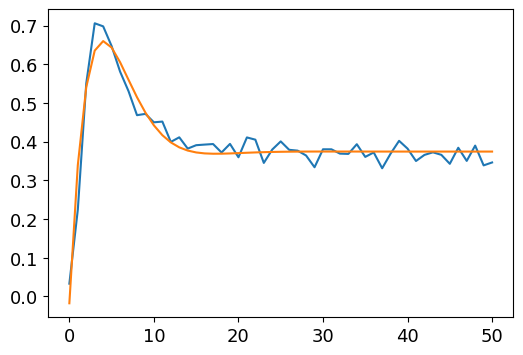



  freq: 0.03751815168318094 +/- 0.005881968856090077
 gamma: 0.2945392524861813 +/- 0.02838730983419789
   amp: 1.4832106233144466 +/- 0.31236886259978436
 phase: -15.32607183345869 +/- 3.125561903802718
offset: 0.3744736271848508 +/- 0.0053024226589565545
pi_pulse time: 13.326882524016918 +/- 0.005881968856090077
J = 0.33: Angular freq (rad/µs): 0.23573349940829755


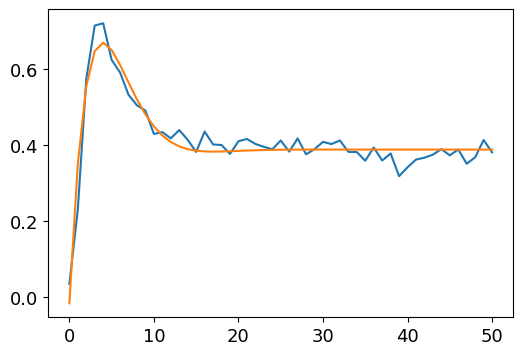



  freq: 0.038279709295873654 +/- 0.0066619370186284605
 gamma: 0.3028584341264487 +/- 0.03148933220038322
   amp: 1.492044768828941 +/- 0.34449632265486246
 phase: -15.75811884335181 +/- 3.5327515079343796
offset: 0.3883837374853003 +/- 0.005683161672211413
pi_pulse time: 13.061750185597603 +/- 0.0066619370186284605
J = 0.34: Angular freq (rad/µs): 0.24051850701093916


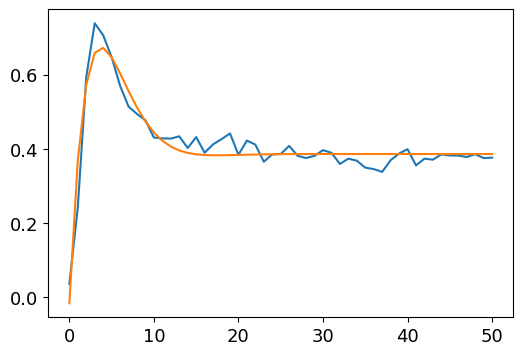



  freq: 0.03664900770846968 +/- 0.007819506742890182
 gamma: 0.32291684470804405 +/- 0.03429433385555684
   amp: 1.6632102571053728 +/- 0.45252173415819347
 phase: -13.99932140857058 +/- 3.713591796887759
offset: 0.38620155706326775 +/- 0.00576606909965394
pi_pulse time: 13.642934181938266 +/- 0.007819506742890182
J = 0.35000000000000003: Angular freq (rad/µs): 0.2302725067565681


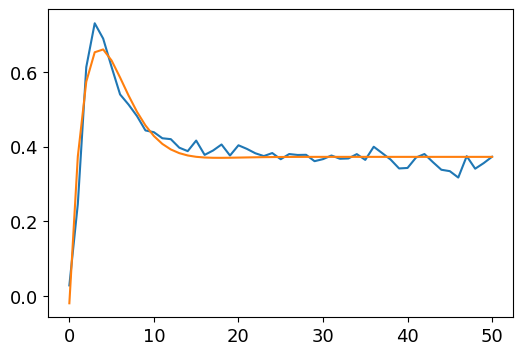



  freq: 0.03556689880899674 +/- 0.008247049488289651
 gamma: 0.3359501004315279 +/- 0.03454510018422819
   amp: 1.7756024644093387 +/- 0.5141391822242084
 phase: -12.771244962448604 +/- 3.6115552029093654
offset: 0.37286231374629675 +/- 0.005499411107143328
pi_pulse time: 14.058015085462658 +/- 0.008247049488289651
J = 0.36: Angular freq (rad/µs): 0.22347341601863144


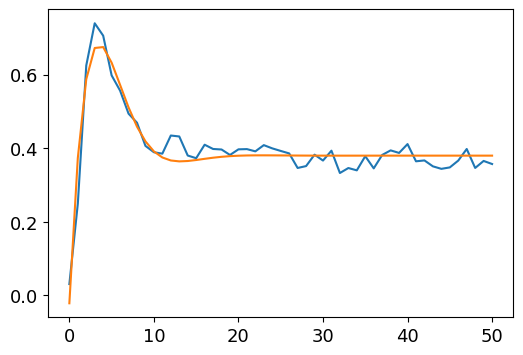



  freq: 0.05205215441200976 +/- 0.005739627463948435
 gamma: 0.30807485781311816 +/- 0.03372120111257145
   amp: 1.2229744758105208 +/- 0.20593825890490877
 phase: -19.151601027668708 +/- 3.143113900285161
offset: 0.37990967379612595 +/- 0.005651260443626878
pi_pulse time: 9.60575034113549 +/- 0.005739627463948435
J = 0.37: Angular freq (rad/µs): 0.3270533318085828


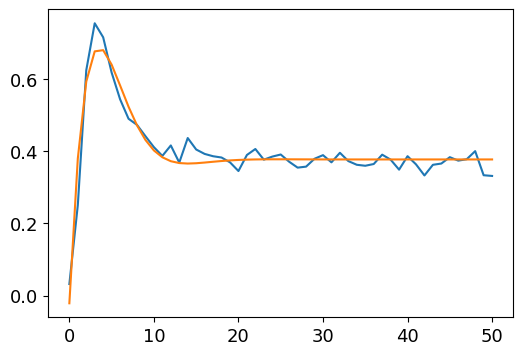



  freq: 0.047700546756791945 +/- 0.005911869192516414
 gamma: 0.3150023442730309 +/- 0.032880484879685735
   amp: 1.3591663707214319 +/- 0.24583550116006578
 phase: -17.028369730491686 +/- 2.996792696130537
offset: 0.3770159287718519 +/- 0.005534413350098667
pi_pulse time: 10.482060143866306 +/- 0.005911869192516414
J = 0.38: Angular freq (rad/µs): 0.299711374526708


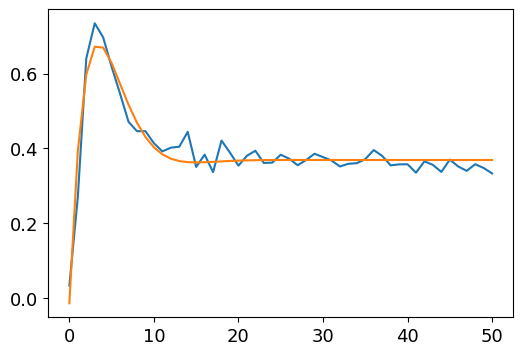



  freq: 0.043287175733205535 +/- 0.0069483999457284696
 gamma: 0.33473891784855714 +/- 0.03504230664150881
   amp: 1.5432119524038426 +/- 0.3381773557066026
 phase: -14.370694611706268 +/- 3.0699804090974125
offset: 0.3692639224640545 +/- 0.005487078164836508
pi_pulse time: 11.550765129184684 +/- 0.0069483999457284696
J = 0.39: Angular freq (rad/µs): 0.2719813465561777


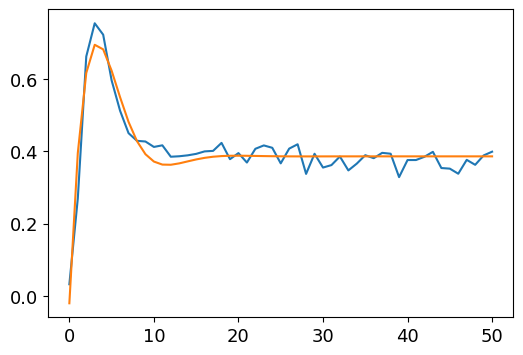



  freq: 0.060531741764812005 +/- 0.005402070219349591
 gamma: 0.3117917873750663 +/- 0.03419034705304924
   amp: 1.1278363725206573 +/- 0.1648009788434888
 phase: -21.132459985026834 +/- 3.0374658280721856
offset: 0.38623908270085805 +/- 0.005545938500021578
pi_pulse time: 8.260129073151127 +/- 0.005402070219349591
J = 0.4: Angular freq (rad/µs): 0.3803321504746557


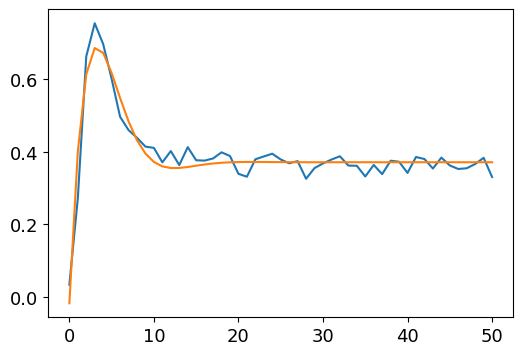



  freq: 0.05472502262553638 +/- 0.005711845636516981
 gamma: 0.3251322717959269 +/- 0.03445983373140936
   amp: 1.2646958427799617 +/- 0.20434295009632875
 phase: -17.87138879673205 +/- 2.833166633828654
offset: 0.371300955635808 +/- 0.005395818908820847
pi_pulse time: 9.136588273728455 +/- 0.005711845636516981
J = 0.41000000000000003: Angular freq (rad/µs): 0.3438474580958406


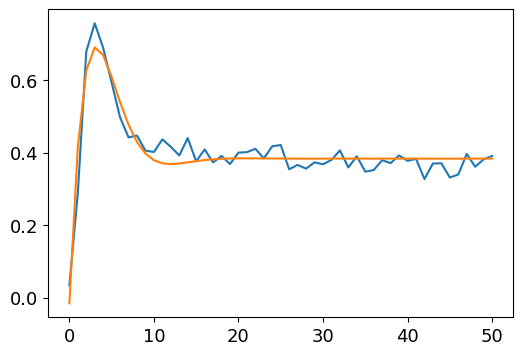



  freq: 0.0568783329280466 +/- 0.006918063220432925
 gamma: 0.34322058575907544 +/- 0.04049006582533224
   amp: 1.2593908805448186 +/- 0.23120583749979473
 phase: -18.460716714580897 +/- 3.334643135118502
offset: 0.3834448548326605 +/- 0.005817048928837346
pi_pulse time: 8.790693648362026 +/- 0.006918063220432925
J = 0.42: Angular freq (rad/µs): 0.35737710575037124


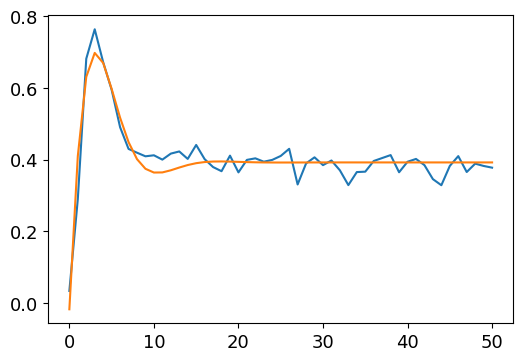



  freq: 0.06826637782341018 +/- 0.005795400419576768
 gamma: 0.32138805551765953 +/- 0.03744569089747678
   amp: 1.0393207732785208 +/- 0.14889360354848072
 phase: -23.233042019940818 +/- 3.3036045463234784
offset: 0.392193334535933 +/- 0.005608175671993481
pi_pulse time: 7.324249739650578 +/- 0.005795400419576768
J = 0.43: Angular freq (rad/µs): 0.4289303021144212


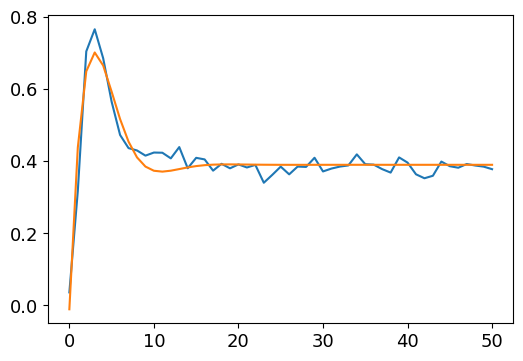



  freq: 0.06335483551101358 +/- 0.006279799798750389
 gamma: 0.35467513456832334 +/- 0.03830634871693759
   amp: 1.196884434787116 +/- 0.185231293640143
 phase: -19.53516798969278 +/- 2.9986190484547
offset: 0.38937166484234137 +/- 0.005170988511005733
pi_pulse time: 7.892057424931365 +/- 0.006279799798750389
J = 0.44: Angular freq (rad/µs): 0.39807017162158


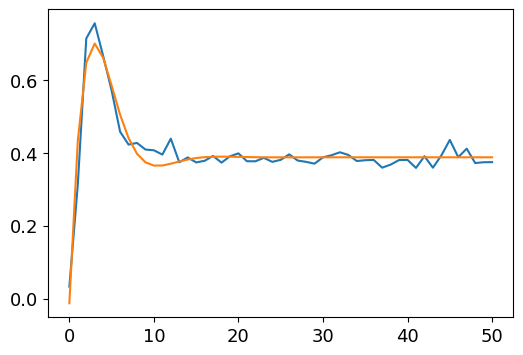



  freq: 0.06695871790838248 +/- 0.005597571397890848
 gamma: 0.3465940553824169 +/- 0.035418859552675666
   amp: 1.1286661921260424 +/- 0.15318685902678508
 phase: -20.804383490758173 +/- 2.8096149642378183
offset: 0.38776469303045463 +/- 0.004863483425912548
pi_pulse time: 7.467287541020937 +/- 0.005597571397890848
J = 0.45: Angular freq (rad/µs): 0.42071403254953144


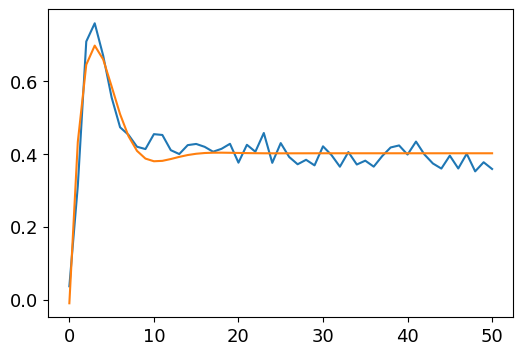



  freq: 0.06818502332759961 +/- 0.007270486447410693
 gamma: 0.3528132326073667 +/- 0.04453648678442373
   amp: 1.0897991755248138 +/- 0.18397817001375172
 phase: -22.208745338532356 +/- 3.7307335064875007
offset: 0.40175410612889684 +/- 0.0058409843121219164
pi_pulse time: 7.332988618302816 +/- 0.007270486447410693
J = 0.46: Angular freq (rad/µs): 0.4284191367416712


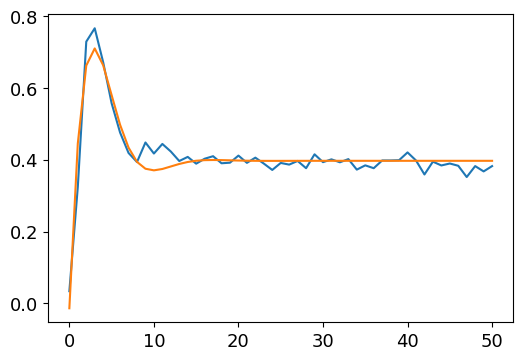



  freq: 0.0710317698226748 +/- 0.005864133683336344
 gamma: 0.3506618051792864 +/- 0.03748145298636613
   amp: 1.0989703729492646 +/- 0.14948832164130818
 phase: -21.974627420809448 +/- 2.987863277715413
offset: 0.39742012430886525 +/- 0.005059804787031022
pi_pulse time: 7.039103787617998 +/- 0.005864133683336344
J = 0.47000000000000003: Angular freq (rad/µs): 0.44630577249279263


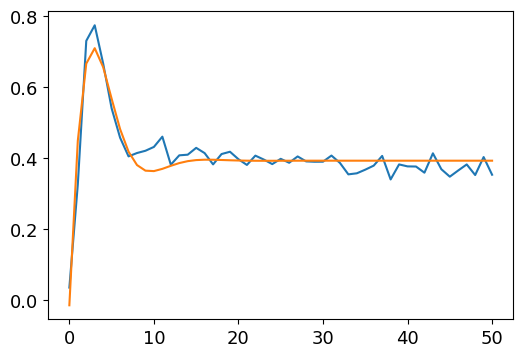



  freq: 0.07401336732122497 +/- 0.0065048228556868265
 gamma: 0.34904959120778023 +/- 0.04262370643025515
   amp: 1.068894894475278 +/- 0.15921850142994426
 phase: -22.375097215108283 +/- 3.3481387644355785
offset: 0.3931917137226109 +/- 0.00573697819974253
pi_pulse time: 6.755536440194012 +/- 0.0065048228556868265
J = 0.48: Angular freq (rad/µs): 0.4650397020876065


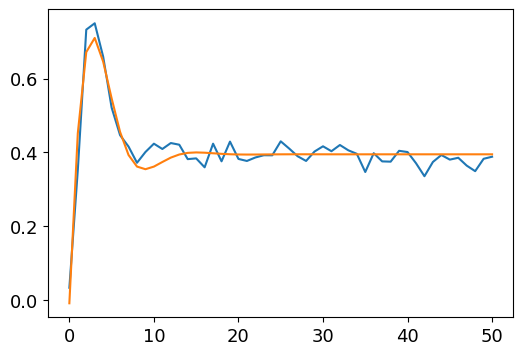



  freq: 0.08167445759629184 +/- 0.00523158731592588
 gamma: 0.33705145584170043 +/- 0.03564878418223643
   amp: 0.96799772218313 +/- 0.11242549247279027
 phase: -24.644555843936896 +/- 2.9056369985405968
offset: 0.3946611216750066 +/- 0.004857651599332319
pi_pulse time: 6.121864958950163 +/- 0.00523158731592588
J = 0.49: Angular freq (rad/µs): 0.513175751940883


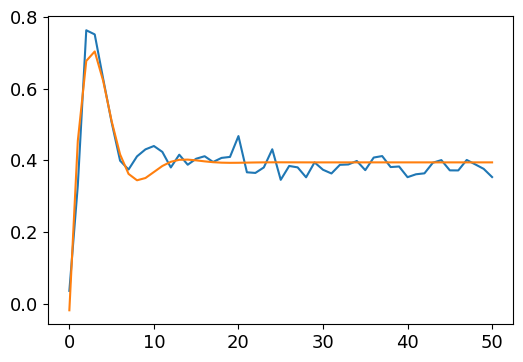



  freq: 0.09106544174514787 +/- 0.006381616655710855
 gamma: 0.3357306579596275 +/- 0.04371176047414999
   amp: 0.8971577389524268 +/- 0.11874151162950605
 phase: -27.404841274404177 +/- 3.7246549233242505
offset: 0.39403836490929617 +/- 0.005845116057993119
pi_pulse time: 5.49055701502311 +/- 0.006381616655710855
J = 0.5: Angular freq (rad/µs): 0.5721810455649317
J = 0.0: omega = 2.9742202686241367e-06 rad/µs
J = 0.01: omega = 1.2159058167892109e-06 rad/µs
J = 0.02: omega = nan rad/µs
J = 0.03: omega = nan rad/µs
J = 0.04: omega = 4.871202495333977e-07 rad/µs
J = 0.05: omega = 1.017605271502347e-06 rad/µs
J = 0.06: omega = 3.2075313159576148e-06 rad/µs
J = 0.07: omega = 1.270173012709499e-07 rad/µs
J = 0.08: omega = 8.694232663171479e-07 rad/µs
J = 0.09: omega = nan rad/µs
J = 0.1: omega = nan rad/µs
J = 0.11: omega = 0.0420395112731613 rad/µs
J = 0.12: omega = nan rad/µs
J = 0.13: omega = nan rad/µs
J = 0.14: omega = 0.06689149007387417 rad/µs
J = 0.15: omega = nan rad/µs
J = 0.16:

In [ ]:
# Now call the function to process each J value and extract the angular frequency
omega_dict = sweep_J_curve_fit(probability_dataframes)

# Print the results
for J, omega in omega_dict.items():
    print(f"J = {J}: omega = {omega} rad/µs")

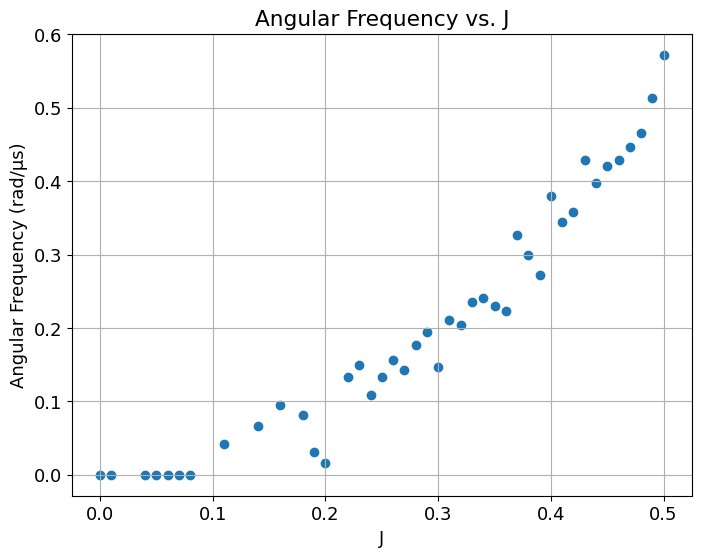

In [ ]:
J_vals = sorted(omega_dict.keys())
omegas = [omega_dict[J] for J in J_vals]

plt.figure(figsize=(8, 6))
plt.scatter(J_vals, omegas, marker='o')
plt.xlabel("J")
plt.ylabel("Angular Frequency (rad/µs)")
plt.title("Angular Frequency vs. J")
plt.grid(True)
plt.show()

In [ ]:
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit_func(J, J0):
    """
    Model function: Re(sqrt(2*(J^2 - J0^2))).
    Returns sqrt(2*(J^2 - J0^2)) if the argument is non-negative;
    otherwise returns 0.

    Parameters:
        J : array_like
            The independent variable.
        J0 : float
            The parameter to fit.

    Returns:
        array_like : The computed model values.
    """
    expr = 2 * (J**2 - J0**2)
    return np.where(expr >= 0, np.sqrt(expr), 0.0)

def curve_fit_function(J_data, y_data, initial_guess_J0=1.0):
    """
    Fits the data (J_data, y_data) to the function
         f(J) = Re(sqrt(2*(J^2 - J0^2)))
    using the provided initial guess for J0.

    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).

    Returns:
        popt : ndarray
            Optimal value for J0.
        pcov : 2D ndarray
            The estimated covariance of popt.
    """
    popt, pcov = curve_fit(fit_func, J_data, y_data, p0=[initial_guess_J0])
    return popt, pcov

def curve_fit_and_plot(J_data, y_data, initial_guess_J0=1.0):
    """
    Fits the given data to the model function (without offset) and plots the original data 
    (scatter plot) along with the fitted curve.

    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).

    Returns:
        popt : ndarray
            The optimal parameter (J0) from the curve fitting.
        pcov : 2D ndarray
            The covariance matrix of the fitted parameter.
    """
    # Perform the curve fit
    popt, pcov = curve_fit_function(J_data, y_data, initial_guess_J0)
    fitted_J0 = popt[0]
    print("Fitted J0 =", fitted_J0)
    
    # Generate a smooth set of points for plotting the fitted curve
    J_fit = np.linspace(np.min(J_data), np.max(J_data), 1000)
    y_fit = fit_func(J_fit, fitted_J0)
    
    # Create the plot: scatter for original data and line for fitted curve
    plt.figure(figsize=(8, 5))
    plt.scatter(J_data, y_data, label='Original Data', color='blue', s=30)
    plt.plot(J_fit, y_fit, label='Fitted Curve', color='red', linewidth=2)
    plt.xlabel('J')
    plt.ylabel('Re(sqrt(2*(J^2 - J0^2)))')
    plt.title('Curve Fit: Data and Fitted Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return popt, pcov

Fitted J0 = 0.2687052959801473


C:\Users\quantum1\AppData\Local\Temp\ipykernel_9036\3847199382.py:23: RuntimeWarning: invalid value encountered in sqrt
  return np.where(expr >= 0, np.sqrt(expr), 0.0)


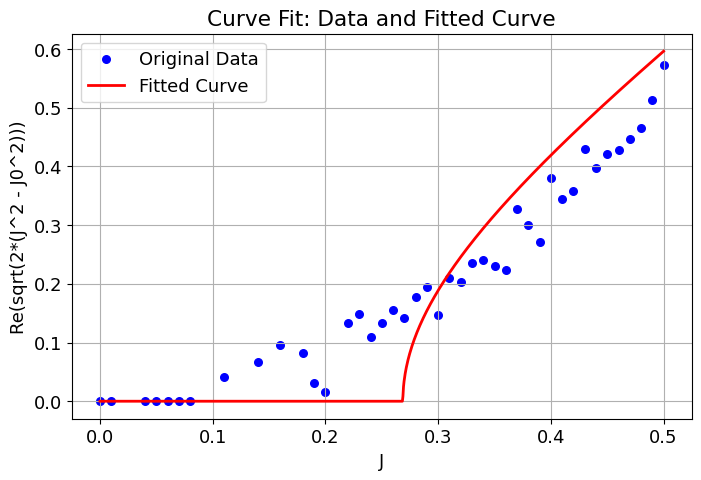

In [ ]:
# Set initial guesses based on your expectations:
initial_guess_J0 = 0.1  # for example
initial_offset = 0.0    # for example
mask_rb = ~np.isnan(omegas)

# Perform the curve fitting and plotting
popt, pcov = curve_fit_and_plot(np.array(J_vals)[mask_rb], np.array(omegas)[mask_rb], initial_guess_J0)

In [ ]:
def run_rabi_ef_no_swap(q1: object, q2: object, general_vals_dict: dict, ef_amp:float,
                     num_steps: int, sweep_time: float, reps: int):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.
    
    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as 
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_no_swap.rabi_ef_no_swap(q1, q2, general_vals_dict,ef_amp, num_steps, sweep_time,)
    wx.wx_set_and_amplitude_and_offset(amp=general_vals_dict["wx_amps"],
                                       offset=general_vals_dict["wx_offs"])
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(q1, q2,
                                num_patterns=num_steps,
                                num_records_per_pattern=reps,
                                verbose=True)
    
    
    
    return  values

def run_swap(q1: object, q2: object, general_vals_dict: dict, swap_freq: float,
                     num_steps: int, sweep_time: float, reps: int):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.
    
    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as 
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.swap(q1, q2, general_vals_dict, num_steps, sweep_time,swap_freq)
    wx.wx_set_and_amplitude_and_offset(amp=general_vals_dict["wx_amps"],
                                       offset=general_vals_dict["wx_offs"])
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(q1, q2,
                                num_patterns=num_steps,
                                num_records_per_pattern=reps,
                                verbose=True)
    
    
    
    return  values



writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 87.381393 sec
Captured 200 buffers (2.288817 buffers per sec)
Captured 614400 records (7031.245183 records per sec)
Transferred 10066329600 bytes (115199921.081921 bytes per sec)


<Figure size 800x800 with 0 Axes>

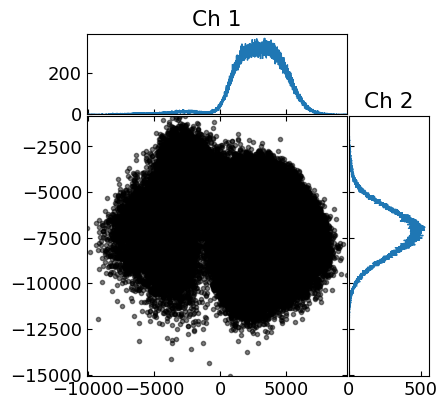

<Figure size 800x800 with 0 Axes>

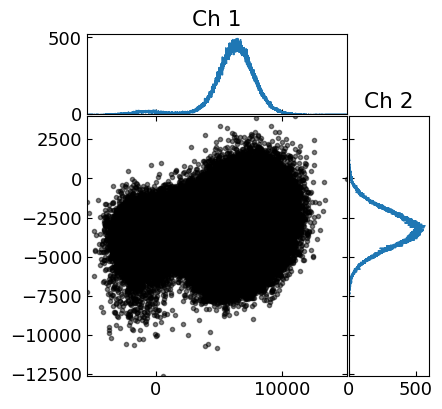

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 76.201431 sec
Captured 200 buffers (2.624623 buffers per sec)
Captured 614400 records (8062.840706 records per sec)
Transferred 10066329600 bytes (132101582.124422 bytes per sec)


<Figure size 800x800 with 0 Axes>

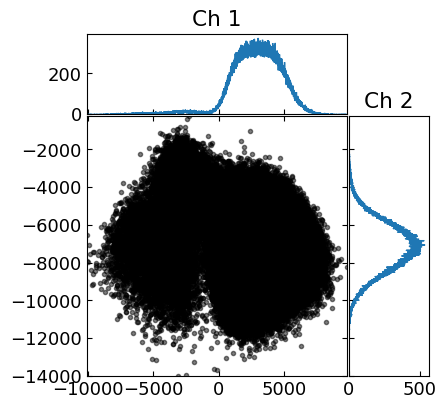

<Figure size 800x800 with 0 Axes>

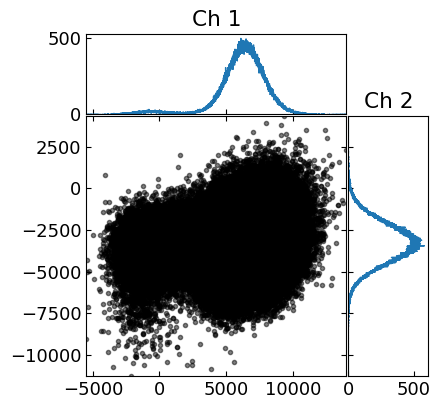

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 72.536404 sec
Captured 200 buffers (2.757236 buffers per sec)
Captured 614400 records (8470.229609 records per sec)
Transferred 10066329600 bytes (138776241.905757 bytes per sec)


<Figure size 800x800 with 0 Axes>

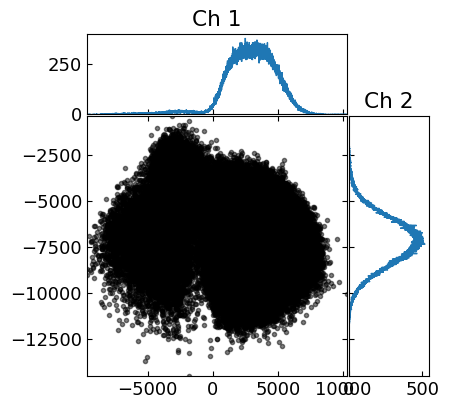

<Figure size 800x800 with 0 Axes>

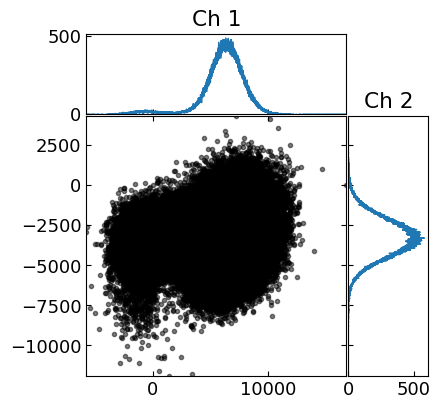

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 83.020860 sec
Captured 200 buffers (2.409033 buffers per sec)
Captured 614400 records (7400.549676 records per sec)
Transferred 10066329600 bytes (121250605.887927 bytes per sec)


<Figure size 800x800 with 0 Axes>

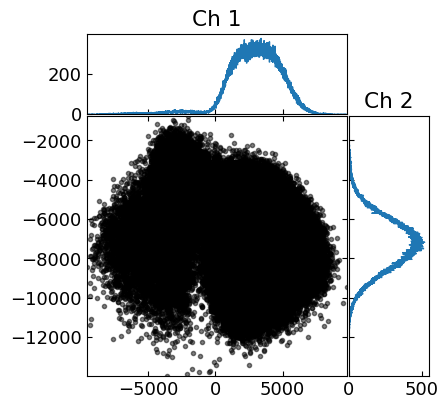

<Figure size 800x800 with 0 Axes>

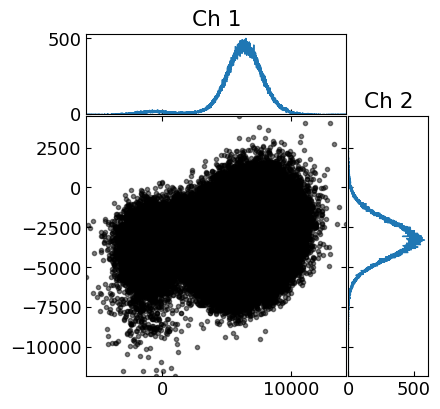

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 70.359442 sec
Captured 200 buffers (2.842547 buffers per sec)
Captured 614400 records (8732.303477 records per sec)
Transferred 10066329600 bytes (143070060.172259 bytes per sec)


<Figure size 800x800 with 0 Axes>

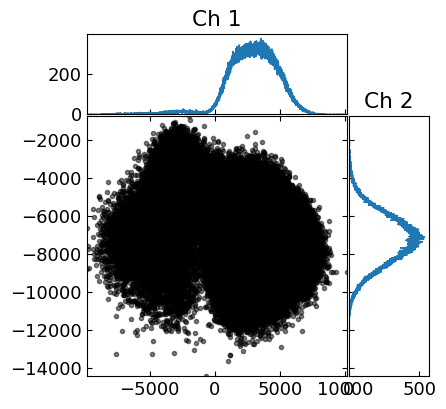

<Figure size 800x800 with 0 Axes>

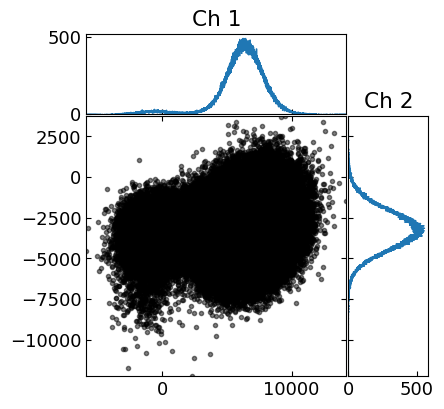

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 77.421951 sec
Captured 200 buffers (2.583247 buffers per sec)
Captured 614400 records (7935.733855 records per sec)
Transferred 10066329600 bytes (130019063.479574 bytes per sec)


<Figure size 800x800 with 0 Axes>

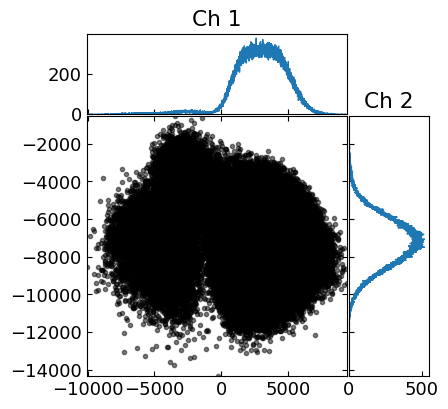

<Figure size 800x800 with 0 Axes>

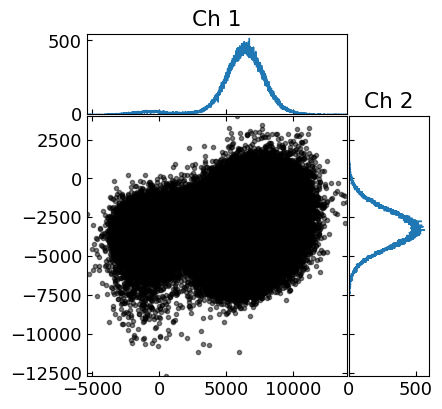

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 77.758521 sec
Captured 200 buffers (2.572065 buffers per sec)
Captured 614400 records (7901.384869 records per sec)
Transferred 10066329600 bytes (129456289.690825 bytes per sec)


<Figure size 800x800 with 0 Axes>

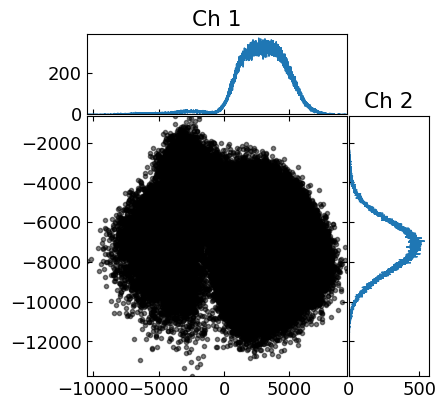

<Figure size 800x800 with 0 Axes>

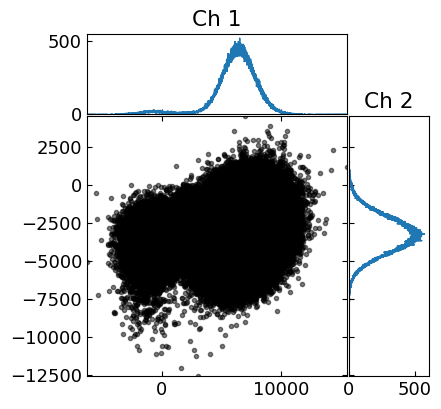

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 72.587544 sec
Captured 200 buffers (2.755294 buffers per sec)
Captured 614400 records (8464.262081 records per sec)
Transferred 10066329600 bytes (138678469.942610 bytes per sec)


<Figure size 800x800 with 0 Axes>

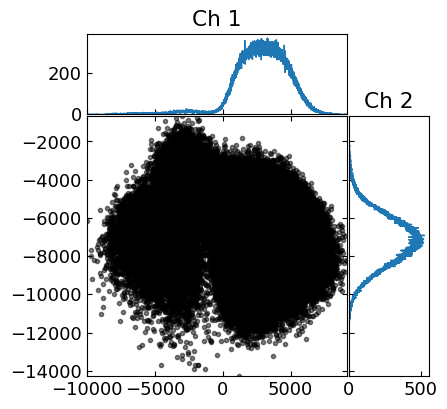

<Figure size 800x800 with 0 Axes>

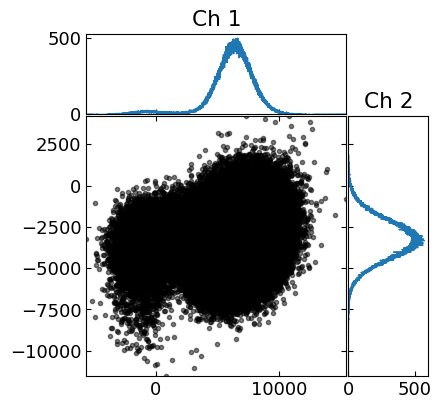

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 80.065944 sec
Captured 200 buffers (2.497941 buffers per sec)
Captured 614400 records (7673.674549 records per sec)
Transferred 10066329600 bytes (125725483.802878 bytes per sec)


<Figure size 800x800 with 0 Axes>

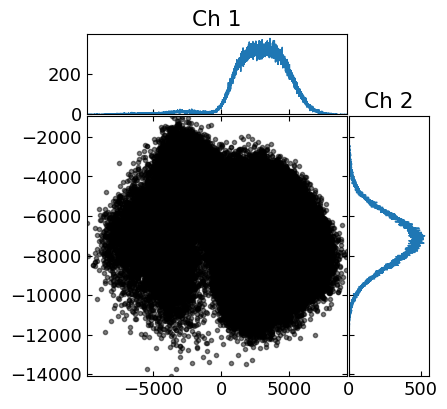

<Figure size 800x800 with 0 Axes>

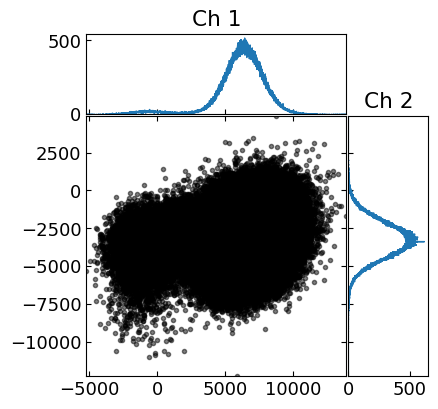

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 74.121398 sec
Captured 200 buffers (2.698276 buffers per sec)
Captured 614400 records (8289.104345 records per sec)
Transferred 10066329600 bytes (135808685.585874 bytes per sec)


<Figure size 800x800 with 0 Axes>

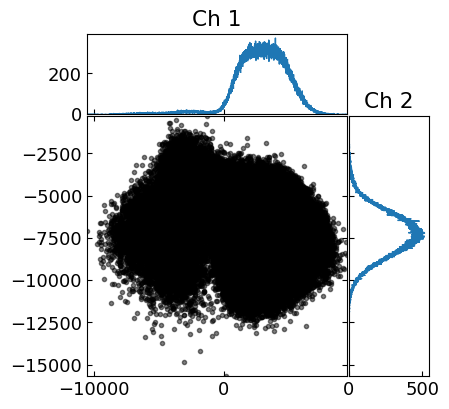

<Figure size 800x800 with 0 Axes>

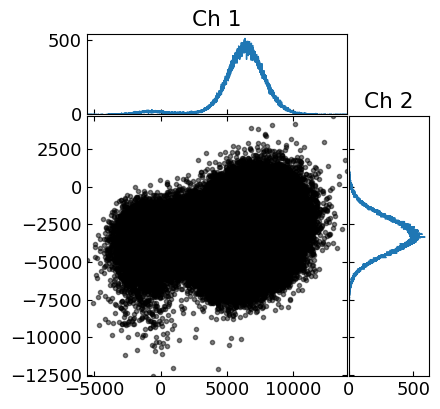

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 78.676736 sec
Captured 200 buffers (2.542047 buffers per sec)
Captured 614400 records (7809.169883 records per sec)
Transferred 10066329600 bytes (127945439.355814 bytes per sec)


<Figure size 800x800 with 0 Axes>

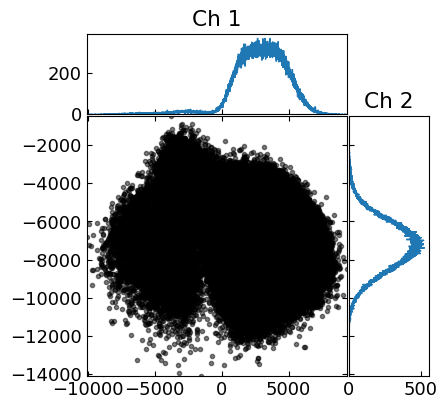

<Figure size 800x800 with 0 Axes>

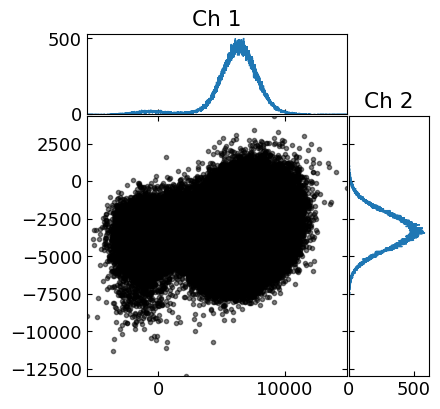

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 73.595151 sec
Captured 200 buffers (2.717570 buffers per sec)
Captured 614400 records (8348.376137 records per sec)
Transferred 10066329600 bytes (136779794.633237 bytes per sec)


<Figure size 800x800 with 0 Axes>

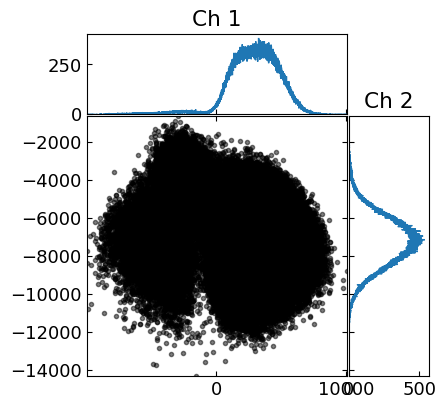

<Figure size 800x800 with 0 Axes>

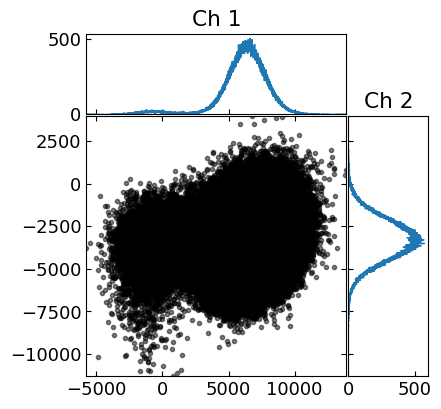

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 70.279120 sec
Captured 200 buffers (2.845795 buffers per sec)
Captured 614400 records (8742.283600 records per sec)
Transferred 10066329600 bytes (143233574.500856 bytes per sec)


<Figure size 800x800 with 0 Axes>

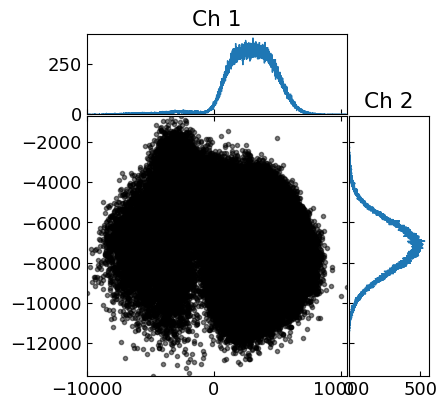

<Figure size 800x800 with 0 Axes>

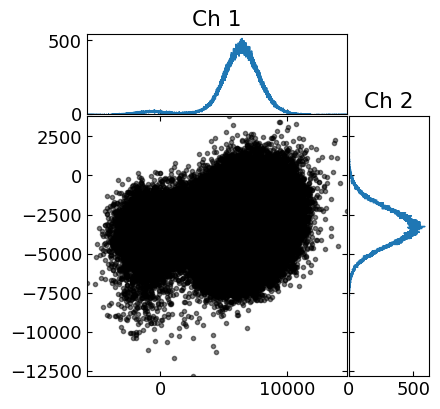

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 85.635687 sec
Captured 200 buffers (2.335475 buffers per sec)
Captured 614400 records (7174.578952 records per sec)
Transferred 10066329600 bytes (117548301.547623 bytes per sec)


<Figure size 800x800 with 0 Axes>

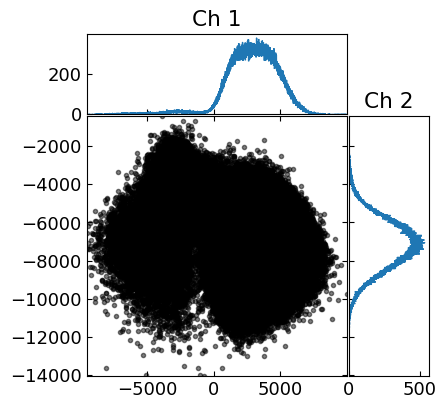

<Figure size 800x800 with 0 Axes>

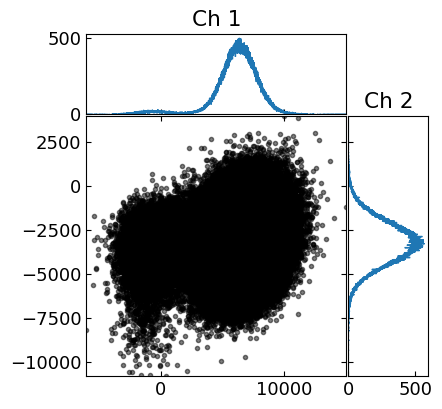

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 71.575156 sec
Captured 200 buffers (2.794266 buffers per sec)
Captured 614400 records (8583.984088 records per sec)
Transferred 10066329600 bytes (140639995.304183 bytes per sec)


<Figure size 800x800 with 0 Axes>

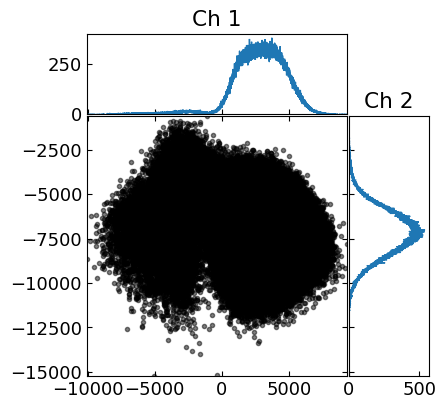

<Figure size 800x800 with 0 Axes>

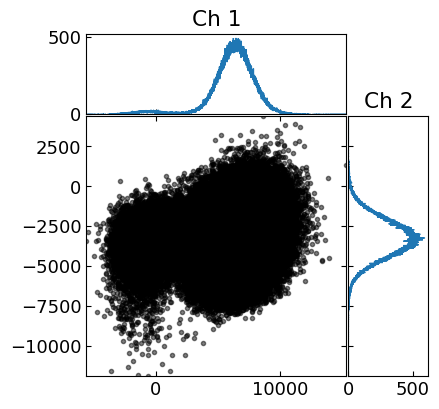

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 81.825536 sec
Captured 200 buffers (2.444225 buffers per sec)
Captured 614400 records (7508.658464 records per sec)
Transferred 10066329600 bytes (123021860.279720 bytes per sec)


<Figure size 800x800 with 0 Axes>

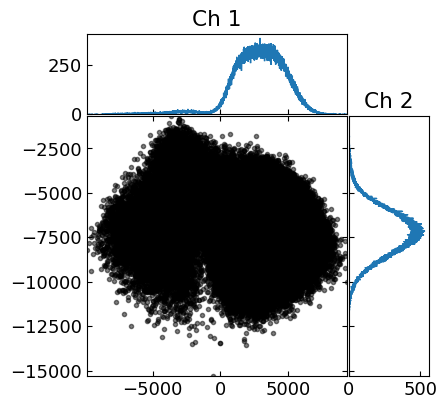

<Figure size 800x800 with 0 Axes>

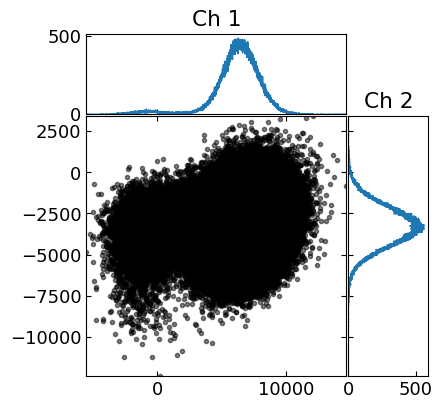

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 74.188787 sec
Captured 200 buffers (2.695825 buffers per sec)
Captured 614400 records (8281.574925 records per sec)
Transferred 10066329600 bytes (135685323.577137 bytes per sec)


<Figure size 800x800 with 0 Axes>

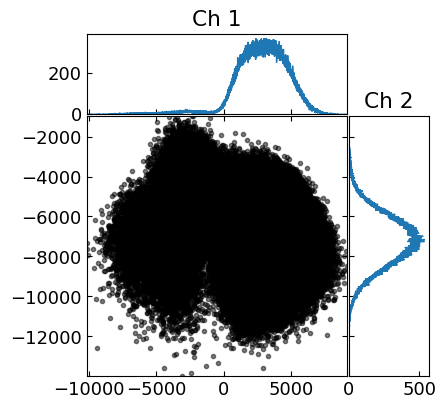

<Figure size 800x800 with 0 Axes>

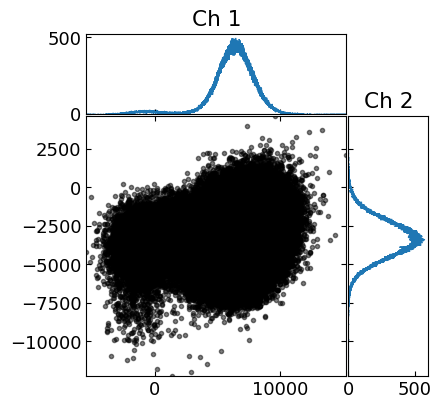

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 75.280546 sec
Captured 200 buffers (2.656729 buffers per sec)
Captured 614400 records (8161.471124 records per sec)
Transferred 10066329600 bytes (133717542.890499 bytes per sec)


<Figure size 800x800 with 0 Axes>

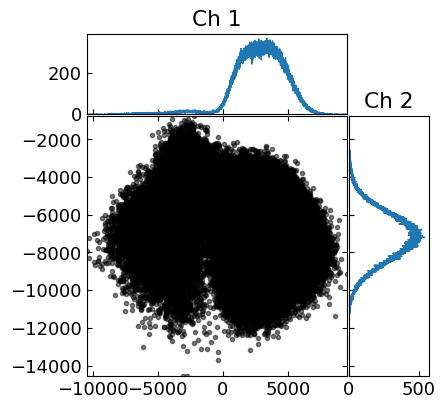

<Figure size 800x800 with 0 Axes>

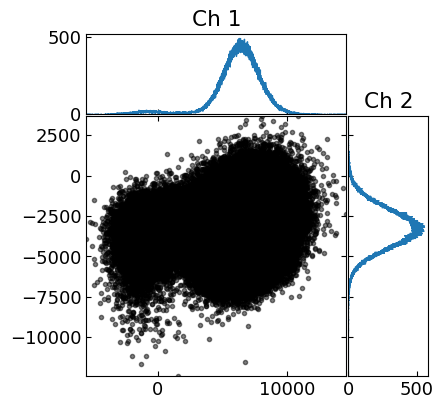

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 67.212025 sec
Captured 200 buffers (2.975658 buffers per sec)
Captured 614400 records (9141.221359 records per sec)
Transferred 10066329600 bytes (149769770.739751 bytes per sec)


<Figure size 800x800 with 0 Axes>

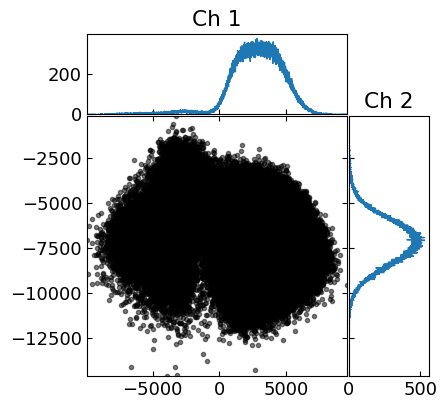

<Figure size 800x800 with 0 Axes>

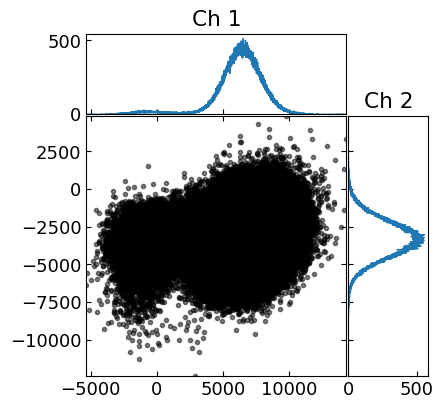

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 65.683526 sec
Captured 200 buffers (3.044904 buffers per sec)
Captured 614400 records (9353.943596 records per sec)
Transferred 10066329600 bytes (153255011.880228 bytes per sec)


<Figure size 800x800 with 0 Axes>

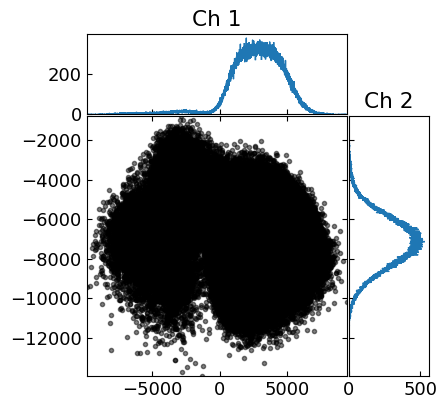

<Figure size 800x800 with 0 Axes>

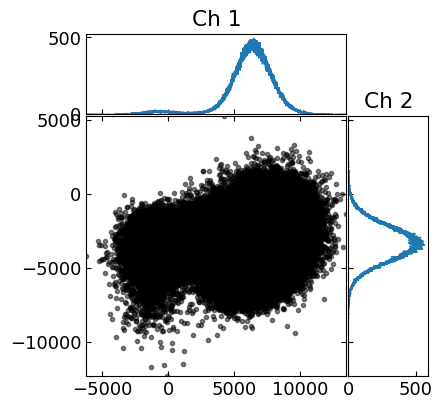

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 65.064503 sec
Captured 200 buffers (3.073873 buffers per sec)
Captured 614400 records (9442.936895 records per sec)
Transferred 10066329600 bytes (154713078.086051 bytes per sec)


<Figure size 800x800 with 0 Axes>

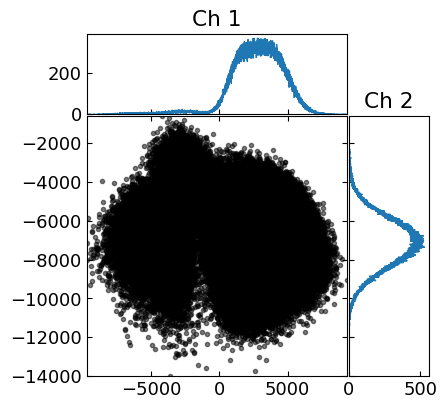

<Figure size 800x800 with 0 Axes>

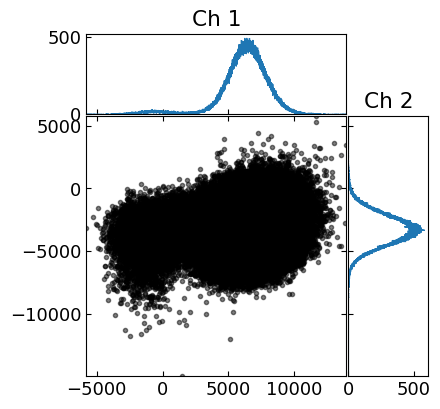

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 64.634382 sec
Captured 200 buffers (3.094328 buffers per sec)
Captured 614400 records (9505.776731 records per sec)
Transferred 10066329600 bytes (155742645.961763 bytes per sec)


<Figure size 800x800 with 0 Axes>

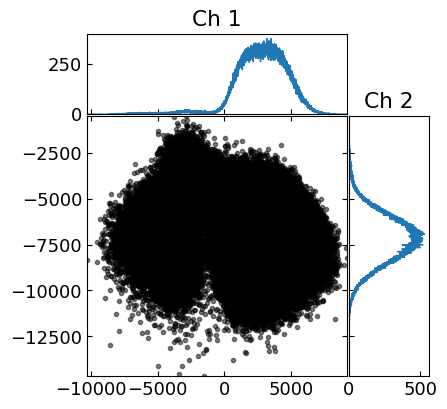

<Figure size 800x800 with 0 Axes>

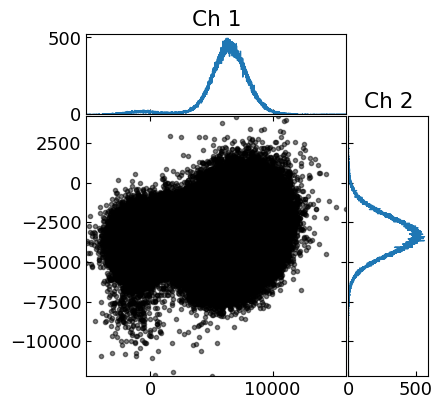

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 64.711100 sec
Captured 200 buffers (3.090660 buffers per sec)
Captured 614400 records (9494.507075 records per sec)
Transferred 10066329600 bytes (155558003.914745 bytes per sec)


<Figure size 800x800 with 0 Axes>

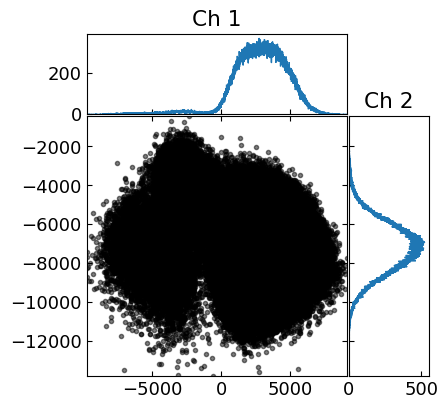

<Figure size 800x800 with 0 Axes>

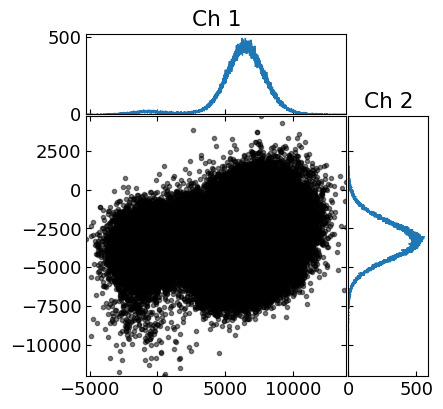

In [ ]:
# num_steps = 51
# reps = 1200
# sweep_time =50000
# swap_freq=-.021
# swap_time=213


# check_df, pop_df, values = run_rabi_ef_swap(q1, q2, general_vals_dict,
#                      num_steps, sweep_time,
#                      swap_freq, swap_time, reps)

# values = run_swap(q1, q2, general_vals_dict,swap_freq , num_steps,swap_time, reps)
#                                    sweep_time, reps)
# df_prob, df_pop, values = run_rabi_ef_no_swap(q1, q2, general_vals_dict,ef_amp , num_steps,
#                                    sweep_time, reps)
J_dict , vals_dict = sweep_J(0,0.5,51)

<Figure size 960x720 with 0 Axes>

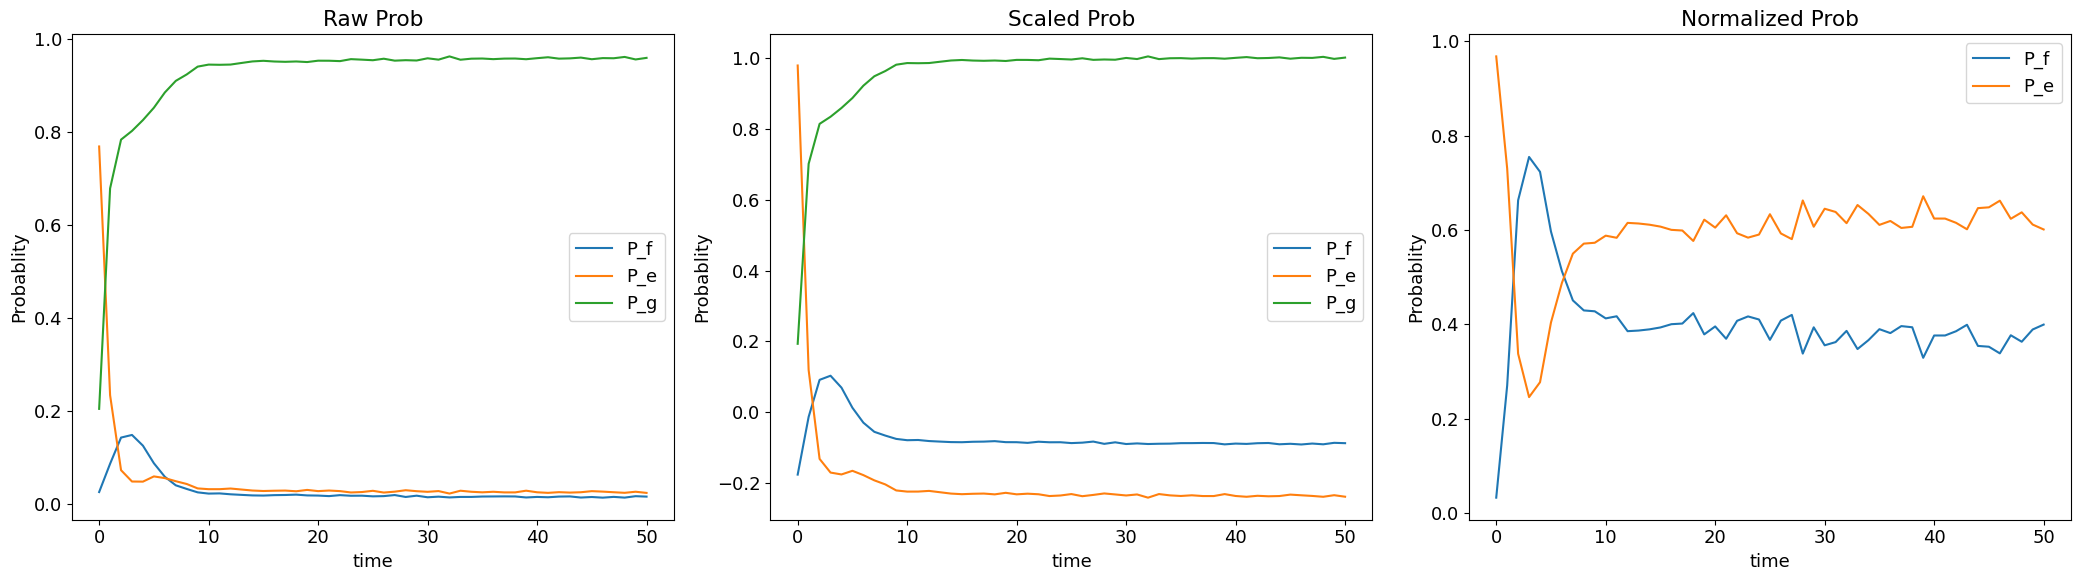

In [ ]:
scale_matrix = np.array([[ 1.04489856, -0.02682748, -0.01807108],
       [-0.28202628,  1.35096177, -0.06893549],
       [-0.10815337, -0.2466758 ,  1.35482917]])

measured_pop = np.array([J_dict[0.4]['P_g'], J_dict[0.4]['P_e'], J_dict[0.4]['P_f']])
scaled_p = np.matmul(scale_matrix, measured_pop)
scaled_df = pd.DataFrame({'time': J_dict[0.4]['time'], 'P_g': scaled_p[0], 'P_e': scaled_p[1], 'P_f': scaled_p[2]})
normalization_val = J_dict[0.4]['P_f'] + J_dict[0.4]['P_e']
normalized_df = pd.DataFrame({'time':J_dict[0.4]['time'], 'P_f':J_dict[0.4]['P_f']/normalization_val,'P_e':J_dict[0.4]['P_e']/normalization_val, "P_g":J_dict[0.4]['P_g']/normalization_val })
keys = ['P_f', 'P_e', "P_g"]
plt.figure(dpi = 150)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for key in keys:
    sns.lineplot(
        data=J_dict[0.4],
        x="time",
        y=key,
        ax=axes[0],
        label = key
    )
    sns.lineplot(
        data=scaled_df,
        x="time",
        y=key,
        ax=axes[1],
        label = key
    )
    if 'P_g' != key:
        sns.lineplot(
            data=normalized_df,
            x="time",
            y=key,
            ax=axes[2],
            label = key
        )
axes[1].set_xlabel("time")
axes[1].set_ylabel("Probablity")
axes[1].set_title("Scaled Prob")
axes[1].legend()
axes[0].set_xlabel("time")
axes[0].set_ylabel("Probablity")
axes[0].set_title("Raw Prob")
axes[0].legend()
axes[2].set_xlabel("time")
axes[2].set_ylabel("Probablity")
axes[2].set_title("Normalized Prob")
axes[2].legend()
# Adjust layout for better spacing
plt.tight_layout()

In [ ]:
J_dict

{0.0:       time       P_f       P_e       P_g
 0.0    0.0  0.027750  0.764000  0.208250
 1.0    1.0  0.026750  0.267500  0.705750
 2.0    2.0  0.024833  0.106500  0.868667
 3.0    3.0  0.019083  0.053167  0.927750
 4.0    4.0  0.018167  0.040083  0.941750
 5.0    5.0  0.017917  0.032833  0.949250
 6.0    6.0  0.017750  0.029500  0.952750
 7.0    7.0  0.016250  0.033083  0.950667
 8.0    8.0  0.018833  0.029750  0.951417
 9.0    9.0  0.015000  0.029917  0.955083
 10.0  10.0  0.017500  0.031417  0.951083
 11.0  11.0  0.014917  0.030667  0.954417
 12.0  12.0  0.018250  0.029500  0.952250
 13.0  13.0  0.016000  0.028917  0.955083
 14.0  14.0  0.018000  0.029583  0.952417
 15.0  15.0  0.016500  0.028000  0.955500
 16.0  16.0  0.014250  0.027583  0.958167
 17.0  17.0  0.017583  0.027167  0.955250
 18.0  18.0  0.016167  0.029250  0.954583
 19.0  19.0  0.014667  0.027833  0.957500
 20.0  20.0  0.015167  0.029667  0.955167
 21.0  21.0  0.015583  0.028750  0.955667
 22.0  22.0  0.015500  0.0325

In [ ]:
# # Retrieve raw IQ data from the acquired values
# values = vals_dict[0]
# I1_raw = values.rec_avg_vs_pats_1[0]
# Q1_raw = values.rec_avg_vs_pats_1[1]
# I2_raw = values.rec_avg_vs_pats_2[0]
# Q2_raw = values.rec_avg_vs_pats_2[1]

# # Build a DataFrame from the IQ data for classification
# IQ_df = pd.DataFrame({
#     "I1": I1_raw,
#     "Q1": Q1_raw,
#     "I2": I2_raw,
#     "Q2": Q2_raw
# })
# Spyder_IQ = pd.read_csv('IQ_data.csv')
# plt.figure(dpi = 200)
# fig, axes = plt.subplots( 2,2, figsize = (14,14))
# # axes[0,0].plot(Spyder_IQ['I1'])
# # axes[0,1].plot(Spyder_IQ['Q1'])
# # axes[1,0].plot(Spyder_IQ['I2'])
# # axes[1,1].plot(Spyder_IQ['Q2'])
# axes[0,0].plot(IQ_df['I1'])
# axes[0,1].plot(IQ_df['Q1'])
# axes[1,0].plot(IQ_df['I2'])
# axes[1,1].plot(Spyder_IQ['Q2'])
# axes[0,0].set_title('I1')
# axes[0,1].set_title('Q1')
# axes[1,0].set_title('I2')
# axes[1,1].set_title('Q2')

In [ ]:
scale_matrix = np.array([[ 1.04489856, -0.02682748, -0.01807108],
       [-0.28202628,  1.35096177, -0.06893549],
       [-0.10815337, -0.2466758 ,  1.35482917]])
# values = vals_dict[0]
P_f = values.prob_vs_pats_1[1]
P_e = values.prob_vs_pats_2[1]
P_g2 = values.prob_vs_pats_2[0]
P_g1 = values.prob_vs_pats_1[0]
spyder_df = pd.read_csv('prob_v_time.csv')
normalization_val = P_f+ P_e
thresh_df = pd.DataFrame({'time':J_dict[0]['time'], 'P_f':P_f, "P_e":P_e, "P_g1":P_g1,"P_g2":P_g2})
#normalized_df = pd.DataFrame({'time':J_dict[0]['time'], 'P_f':thresh_df['P_f']/normalization_val,'P_e':thresh_df['P_e']/normalization_val, "P_g":thresh_df['P_g']/normalization_val })
keys = ['P_f', 'P_e', 'P_g']
plt.figure(dpi = 150)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for key in keys:
    sns.lineplot(
        data=J_dict[0],
        x="time",
        y=key,
        ax=axes[0],
        label = key
    )
    sns.lineplot(
            data=spyder_df_prob,
            x="time",
            y=key,
            ax=axes[2],
            label = key
        )
    if 'P_g' != key:
        # sns.lineplot(
        #     data=spyder_df,
        #     x="time",
        #     y=key,
        #     ax=axes[2],
        #     label = key
        # )
        sns.lineplot(
            data=thresh_df,
            x="time",
            y=key,
            ax=axes[1],
            label = key
        )
for new_key in ['P_g1', 'P_g2']:
    # sns.lineplot(data=spyder_df,
    #             x='time',
    #             y = new_key,
    #             ax = axes[2],
    #             label = new_key)
    sns.lineplot(data=thresh_df,
                x='time',
                y = new_key,
                ax = axes[1],
                label = new_key)

axes[1].set_xlabel("time")
axes[1].set_ylabel("Probablity")
axes[1].set_title("Threshold Prob")
axes[1].legend()
axes[0].set_xlabel("time")
axes[0].set_ylabel("Probablity")
axes[0].set_title("ML Prob")
axes[0].legend()
axes[2].set_xlabel("time")
axes[2].set_ylabel("Probablity")
axes[2].set_title("Spyder Prob")
axes[2].legend()

for i in range(3):
    axes[i].set_ylim([0,1])
# Adjust layout for better spacing
plt.tight_layout()



NameError: name 'values' is not defined

In [ ]:

# Retrieve raw IQ data from the acquired values
I1_raw = values.rec_readout_1[0][0:reps*num_steps]
Q1_raw = values.rec_readout_1[1][0:reps*num_steps]
I2_raw = values.rec_readout_2[0][0:reps*num_steps]
Q2_raw = values.rec_readout_2[1][0:reps*num_steps]

# Build a DataFrame from the IQ data for classification
IQ_df = pd.DataFrame({
    "I1": I1_raw,
    "Q1": Q1_raw,
    "I2": I2_raw,
    "Q2": Q2_raw
})
# Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
classified = classifier.classify(IQ_df)

In [ ]:
dir(values)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'bins_1',
 'bins_2',
 'counts_1',
 'counts_2',
 'n_readout_1',
 'n_readout_2',
 'n_vs_pats_1',
 'n_vs_pats_2',
 'prob_vs_pats_1',
 'prob_vs_pats_2',
 'rec_all',
 'rec_all_het_1',
 'rec_all_het_2',
 'rec_avg_all',
 'rec_avg_vs_pats_1',
 'rec_avg_vs_pats_2',
 'rec_readout_1',
 'rec_readout_2',
 'rec_readout_vs_pats_1',
 'rec_readout_vs_pats_2']

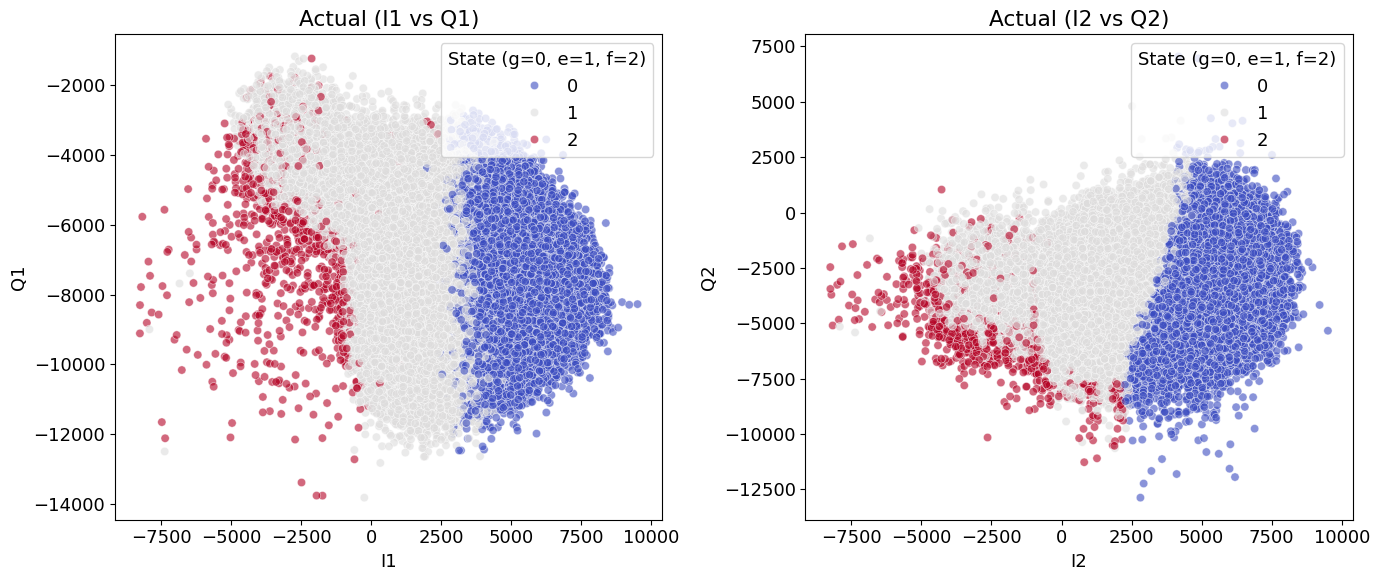

In [ ]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
time_step = 49
data_cut =spyder_IQ.copy() #IQ_df.iloc[time_step * reps: time_step*reps + reps]
# First subplot: I1 vs Q1
sns.scatterplot(
    data=data_cut,
    x="I1",
    y="Q1",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Actual (I1 vs Q1)")
axes[0].legend(title="State (g=0, e=1, f=2)", loc = 'upper right')

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=data_cut,
    x="I2",
    y="Q2",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Actual (I2 vs Q2)")
axes[1].legend(title="State (g=0, e=1, f=2)", loc = 'upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()